## MACHINE TRANSLATION PROJECT (ENGLISH TO FRENCH)

In [34]:
import json
import numpy as np
import collections

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Dense,GRU,LSTM,Embedding,Bidirectional,Dropout,Activation,TimeDistributed,RepeatVector
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy

### TO see the GPU in system

In [35]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5890975765034539035
xla_global_id: -1
]


### LOADIND DATA

In [36]:
def load_data(path):
    input_file=path
    with open(input_file,"r") as f:
        data = f.read()
    return data.split('\n')
english_sentences = load_data("data/english")
french_sentences = load_data("data/french")


### Sample data

In [37]:
print(english_sentences[:5])
print(french_sentences[:5])


['new jersey is sometimes quiet during autumn , and it is snowy in april .', 'the united states is usually chilly during july , and it is usually freezing in november .', 'california is usually quiet during march , and it is usually hot in june .', 'the united states is sometimes mild during june , and it is cold in september .', 'your least liked fruit is the grape , but my least liked is the apple .']
["new jersey est parfois calme pendant l' automne , et il est neigeux en avril .", 'les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .', 'california est généralement calme en mars , et il est généralement chaud en juin .', 'les états-unis est parfois légère en juin , et il fait froid en septembre .', 'votre moins aimé fruit est le raisin , mais mon moins aimé est la pomme .']


In [38]:
english_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])

print('{} English words'.format(len([word for sentence in english_sentences for word in sentence.split()] )))
print(f"Unique English Words {len(english_counter)}")
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_counter.most_common(10)))[0]) + '"')#get only the words zero indicates the first list contains only words
print(f"{english_counter.most_common(10)}")
print()

print('{} French words'.format(len([word for sentence in french_sentences for word in sentence.split()] )))
print(f"Unique rench Words {len(french_counter)}")
print('10 Most common words in the french dataset:')
#print('"' + '" "'.join(list(zip(*french_counter.most_common(10)))[0]) + '"')
print(f"{french_counter.most_common(10)}")


    

1823250 English words
Unique English Words 227
10 Most common words in the English dataset:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"
[('is', 205858), (',', 140897), ('.', 129039), ('in', 75525), ('it', 75137), ('during', 74933), ('the', 67628), ('but', 63987), ('and', 59850), ('sometimes', 37746)]

1961295 French words
Unique rench Words 355
10 Most common words in the french dataset:
[('est', 196809), ('.', 135619), (',', 123135), ('en', 105768), ('il', 84079), ('les', 65255), ('mais', 63987), ('et', 59851), ('la', 49861), ('parfois', 37746)]


### PREPROCESSING

#### 1.TOKENIZATION
#### 2.PADDING

In [39]:
def tokenize(x):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    return tokenizer.texts_to_sequences(x),tokenizer 
#tokenizer.text_to_sequence(x) retuns the sequnce
#tokenizer is like a tuple it contains a word with their index number to see print(tokenizer.word_index)


    

In [40]:
def pad(x,length=None):
    if length is None:
        length=max([len(sentence) for sentence in x])
    return pad_sequences(x,maxlen=length,padding='post')
# used to pad the values ex [1,2],[2,3,4],[1,2,3,4,5]
# result is [1,2,,0,0,0],[2,3,4,0,0],[1,2,3,4,5]
# padding='post' used pad values at last 
# The model takes only same length of values

### PEPROCESSING

In [41]:
def preprocess(x,y):
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)
    
    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)
    
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape,1)
    
    return preprocess_x,preprocess_y,x_tk,y_tk

prepro_english_sentence,prepro_french_sentence,english_tokenizer,french_tokenizer = preprocess(english_sentences,french_sentences)

max_english_sequence_length = prepro_english_sentence.shape[1]
max_french_sequence_length = prepro_french_sentence.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

In [42]:
print("Preprocessed English Sentences:\n", prepro_english_sentence)
print("Preprocessed French Sentences:\n", prepro_french_sentence)
print("English Tokenizer Word Index:\n", english_tokenizer.word_index)
print("French Tokenizer Word Index:\n", french_tokenizer.word_index)
print()

# TO find the maximum values
print("Max value of Preprocessed English Sentences:\n", prepro_english_sentence.shape[1])
print("Max value of Preprocessed French Sentences:\n", prepro_french_sentence.shape[1])
print("Max value of English Tokenizer Word Index:\n", len(english_tokenizer.word_index))
print("Max value of French Tokenizer Word Index:\n", len(french_tokenizer.word_index))
print()

Preprocessed English Sentences:
 [[17 23  1 ... 44  0  0]
 [ 5 20 21 ... 51  2 45]
 [22  1  9 ... 34  0  0]
 ...
 [24  1 10 ... 54  0  0]
 [ 5 84  1 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
Preprocessed French Sentences:
 [[[ 35]
  [ 34]
  [  1]
  ...
  [  0]
  [  0]
  [  0]]

 [[  4]
  [ 32]
  [ 31]
  ...
  [  0]
  [  0]
  [  0]]

 [[101]
  [  1]
  [ 12]
  ...
  [  0]
  [  0]
  [  0]]

 ...

 [[  7]
  [ 33]
  [  1]
  ...
  [  0]
  [  0]
  [  0]]

 [[ 84]
  [  1]
  [ 20]
  ...
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  ...
  [  0]
  [  0]
  [  0]]]
English Tokenizer Word Index:
 {'is': 1, 'in': 2, 'it': 3, 'during': 4, 'the': 5, 'but': 6, 'and': 7, 'sometimes': 8, 'usually': 9, 'never': 10, 'favorite': 11, 'least': 12, 'fruit': 13, 'most': 14, 'loved': 15, 'liked': 16, 'new': 17, 'paris': 18, 'india': 19, 'united': 20, 'states': 21, 'california': 22, 'jersey': 23, 'france': 24, 'china': 25, 'he': 26, 'she': 27, 'grapefruit': 28, 'your': 29, 'my': 30, 'his': 31, 'her': 32, 'fall

# Models

#### Model 1 simple RNN
#### Model 2 bidirectional RNN
#### Model 3 Embedding RNN

### Ids Back to Text
The neural network will be translating the input to words ids, which isn't the final form we want.  We want the French translation.  The function `logits_to_text` will bridge the gab between the logits from the neural network to the French translation.  You'll be using this function to better understand the output of the neural network.

In [43]:
def logits_to_text(logits, tokenizer):
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'
    
    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

##### Above function explanation
Original Mapping (tokenizer.word_index):

Maps words to unique integer indices.
Example: {'i': 1, 'love': 2, 'machine': 3, ...}
Reversed Mapping (index_to_words):

Maps integer indices back to words.
Example: {1: 'i', 2: 'love', 3: 'machine', ...}
Padding Index:

Adds a special entry for the padding index.
Example: {0: '<PAD>', 1: 'i', 2: 'love', ...}
This reversed mapping (index_to_words) is used in the logits_to_text function to convert the predicted indices back into readable words.

##### List Comprehension:

[index_to_words[prediction] for prediction in np.argmax(logits, 1)]

This is a list comprehension that iterates over the array of predicted indices.

For each predicted index (prediction), it looks up the corresponding word in the index_to_words dictionary.

Example:
Given index_to_words:
python
Copy code
{0: '<PAD>', 1: 'hello', 2: 'world', 3: 'test'}
For the predicted indices [1, 0, 2], the list comprehension will produce:
python
Copy code
['hello', '<PAD>', 'world']
' '.join(...):

The join method combines the list of words into a single string, with each word separated by a space.
"hello <PAD> world"

### MODEL 1 RNN

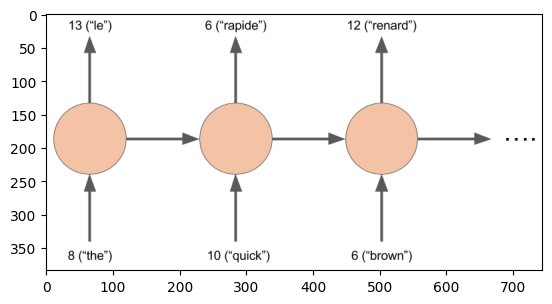

In [44]:
import cv2 as opencv
from matplotlib import pyplot as plt
img = opencv.imread("images/rnn.png")
plt.imshow(img)

In [45]:
def simple_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    
    #Hyperparameters
    learning_rate = 0.005
    
    # Build the layers
    model = Sequential()
    model.add(GRU(256, input_shape=input_shape[1:], return_sequences=True))
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(french_vocab_size, activation='softmax')))
    
    # Compile model
    model.compile(loss = sparse_categorical_crossentropy,
                  optimizer = Adam(learning_rate),
                  metrics = ['accuracy'])
    
    return model

tmp_x = pad(prepro_english_sentence, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, prepro_french_sentence.shape[-2], 1))

#Train the neural network
simple_rnn_model = simple_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size,
    french_vocab_size)

simple_rnn_model.fit(tmp_x, prepro_french_sentence, batch_size=1024, epochs=10, validation_split=0.2)

Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4598 - loss: 2.6437

InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "c:\Users\brije\anaconda3\envs\nullclass\lib\runpy.py", line 197, in _run_module_as_main

  File "c:\Users\brije\anaconda3\envs\nullclass\lib\runpy.py", line 87, in _run_code

  File "c:\Users\brije\anaconda3\envs\nullclass\lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "c:\Users\brije\anaconda3\envs\nullclass\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "c:\Users\brije\anaconda3\envs\nullclass\lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\Users\brije\anaconda3\envs\nullclass\lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\brije\anaconda3\envs\nullclass\lib\asyncio\base_events.py", line 601, in run_forever

  File "c:\Users\brije\anaconda3\envs\nullclass\lib\asyncio\base_events.py", line 1905, in _run_once

  File "c:\Users\brije\anaconda3\envs\nullclass\lib\asyncio\events.py", line 80, in _run

  File "c:\Users\brije\anaconda3\envs\nullclass\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "c:\Users\brije\anaconda3\envs\nullclass\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "c:\Users\brije\anaconda3\envs\nullclass\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "c:\Users\brije\anaconda3\envs\nullclass\lib\site-packages\ipykernel\ipkernel.py", line 359, in execute_request

  File "c:\Users\brije\anaconda3\envs\nullclass\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "c:\Users\brije\anaconda3\envs\nullclass\lib\site-packages\ipykernel\ipkernel.py", line 446, in do_execute

  File "c:\Users\brije\anaconda3\envs\nullclass\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\brije\anaconda3\envs\nullclass\lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell

  File "c:\Users\brije\anaconda3\envs\nullclass\lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell

  File "c:\Users\brije\anaconda3\envs\nullclass\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\brije\anaconda3\envs\nullclass\lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async

  File "c:\Users\brije\anaconda3\envs\nullclass\lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes

  File "c:\Users\brije\anaconda3\envs\nullclass\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code

  File "C:\Users\brije\AppData\Local\Temp\ipykernel_14812\2056129944.py", line 30, in <module>

  File "c:\Users\brije\anaconda3\envs\nullclass\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\brije\anaconda3\envs\nullclass\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 339, in fit

  File "c:\Users\brije\anaconda3\envs\nullclass\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\brije\anaconda3\envs\nullclass\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 425, in evaluate

  File "c:\Users\brije\anaconda3\envs\nullclass\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 161, in one_step_on_iterator

  File "c:\Users\brije\anaconda3\envs\nullclass\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 150, in one_step_on_data

  File "c:\Users\brije\anaconda3\envs\nullclass\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 81, in test_step

  File "c:\Users\brije\anaconda3\envs\nullclass\lib\site-packages\keras\src\trainers\trainer.py", line 316, in compute_loss

  File "c:\Users\brije\anaconda3\envs\nullclass\lib\site-packages\keras\src\trainers\compile_utils.py", line 609, in __call__

  File "c:\Users\brije\anaconda3\envs\nullclass\lib\site-packages\keras\src\trainers\compile_utils.py", line 645, in call

  File "c:\Users\brije\anaconda3\envs\nullclass\lib\site-packages\keras\src\losses\loss.py", line 43, in __call__

  File "c:\Users\brije\anaconda3\envs\nullclass\lib\site-packages\keras\src\losses\losses.py", line 22, in call

  File "c:\Users\brije\anaconda3\envs\nullclass\lib\site-packages\keras\src\losses\losses.py", line 1722, in sparse_categorical_crossentropy

  File "c:\Users\brije\anaconda3\envs\nullclass\lib\site-packages\keras\src\ops\nn.py", line 1567, in sparse_categorical_crossentropy

  File "c:\Users\brije\anaconda3\envs\nullclass\lib\site-packages\keras\src\backend\tensorflow\nn.py", line 638, in sparse_categorical_crossentropy

Received a label value of 344 which is outside the valid range of [0, 344).  Label values: 7 88 1 64 16 13 14 5 7 83 1 40 13 14 0 0 0 0 0 0 0 11 30 1 67 15 25 22 47 6 3 1 58 69 2 56 0 0 0 0 0 0 62 1 92 2 41 5 3 1 9 21 26 11 24 0 0 0 0 0 0 0 0 7 33 1 9 7 102 2 51 5 3 1 18 2 45 0 0 0 0 0 0 0 29 1 65 37 11 44 6 3 1 9 21 2 52 0 0 0 0 0 0 0 0 10 38 1 20 16 17 13 5 10 82 1 20 13 17 0 0 0 0 0 0 0 36 1 12 67 37 11 46 5 3 1 18 2 44 0 0 0 0 0 0 0 0 27 145 7 97 134 154 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 113 115 184 110 176 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 94 4 28 4 73 6 4 78 0 0 0 0 0 0 0 0 0 0 0 0 11 30 1 19 15 25 79 56 5 3 1 68 2 41 0 0 0 0 0 0 0 3 55 4 72 4 28 76 6 4 28 0 0 0 0 0 0 0 0 0 0 0 3 55 4 78 4 74 6 4 73 0 0 0 0 0 0 0 0 0 0 0 0 3 55 4 28 4 70 6 4 72 0 0 0 0 0 0 0 0 0 0 0 0 11 30 1 12 57 15 25 22 45 6 3 1 12 18 2 47 0 0 0 0 0 4 32 31 1 8 68 15 25 22 47 5 3 1 8 21 2 41 0 0 0 0 10 82 1 61 16 17 5 7 86 1 40 93 0 0 0 0 0 0 0 0 0 10 85 1 20 16 17 13 5 7 83 1 61 13 17 0 0 0 0 0 0 0 10 38 1 40 16 17 5 7 89 1 39 17 0 0 0 0 0 0 0 0 0 62 1 12 63 2 41 5 3 1 8 60 26 11 24 0 0 0 0 0 0 0 99 124 4 70 4 73 6 28 76 0 0 0 0 0 0 0 0 0 0 0 0 7 89 1 39 16 13 14 5 7 90 27 1 13 14 0 0 0 0 0 0 0 10 85 1 39 13 14 108 96 5 10 82 1 20 13 14 0 0 0 0 0 0 36 1 8 18 2 43 5 3 1 12 66 2 48 0 0 0 0 0 0 0 0 20 13 16 17 1 7 88 5 39 17 13 1 10 82 0 0 0 0 0 0 0 20 16 10 23 14 1 10 85 5 61 23 14 1 7 90 0 0 0 0 0 0 35 34 1 8 19 2 43 5 3 1 8 18 2 49 0 0 0 0 0 0 0 4 32 31 1 9 57 37 11 46 5 3 1 18 2 41 0 0 0 0 0 0 36 1 8 57 2 52 5 3 1 8 59 2 46 0 0 0 0 0 0 0 0 3 94 4 71 4 74 6 4 78 0 0 0 0 0 0 0 0 0 0 0 0 64 16 17 1 10 270 5 61 17 1 7 86 0 0 0 0 0 0 0 0 0 29 1 19 2 52 6 3 1 9 60 2 46 0 0 0 0 0 0 0 0 0 29 1 8 66 2 41 5 3 1 12 60 26 11 24 0 0 0 0 0 0 0 29 1 12 21 37 11 24 5 3 1 9 65 2 51 0 0 0 0 0 0 0 29 1 8 66 15 111 22 11 24 6 3 1 9 26 63 2 53 0 0 0 0 4 32 31 1 21 2 43 5 3 1 9 117 2 47 0 0 0 0 0 0 0 7 36 1 8 65 37 11 46 5 3 1 63 2 44 0 0 0 0 0 0 0 33 1 57 2 49 5 3 1 18 2 47 0 0 0 0 0 0 0 0 0 0 7 33 1 8 63 2 50 6 3 1 12 18 2 49 0 0 0 0 0 0 0 36 1 69 21 2 50 6 3 1 8 63 26 11 24 0 0 0 0 0 0 0 7 33 1 12 65 2 54 6 3 1 19 2 41 0 0 0 0 0 0 0 0 20 16 17 1 13 7 86 5 40 13 17 1 10 85 0 0 0 0 0 0 0 39 109 17 1 13 146 11 237 0 0 0 0 0 0 0 0 0 0 0 0 0 7 88 1 7 13 14 108 96 5 10 85 1 64 13 14 0 0 0 0 0 0 64 16 17 13 1 10 38 5 40 13 140 1 84 0 0 0 0 0 0 0 0 62 1 21 2 50 5 3 1 12 18 2 53 0 0 0 0 0 0 0 0 0 35 34 1 66 2 41 5 3 1 12 67 26 11 24 0 0 0 0 0 0 0 4 32 31 105 131 9 190 2 45 5 3 1 18 2 44 0 0 0 0 0 0 27 94 7 148 97 162 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 29 1 58 69 2 50 5 3 1 12 19 2 53 0 0 0 0 0 0 0 0 99 127 91 28 76 4 70 6 4 74 0 0 0 0 0 0 0 0 0 0 0 4 32 31 1 12 63 37 11 24 6 3 1 8 58 2 41 0 0 0 0 0 27 55 4 75 4 73 6 10 38 0 0 0 0 0 0 0 0 0 0 0 0 4 32 31 1 8 21 37 11 24 6 3 1 12 67 2 52 0 0 0 0 0 62 1 12 65 37 11 44 6 3 1 8 10 81 2 50 0 0 0 0 0 0 11 30 1 12 18 15 25 79 56 5 3 1 8 18 2 46 0 0 0 0 0 101 1 12 18 15 25 22 47 6 3 1 60 2 52 0 0 0 0 0 0 0 29 1 19 2 41 6 3 1 12 19 2 53 0 0 0 0 0 0 0 0 0 7 33 1 9 18 26 98 6 3 1 8 67 2 44 0 0 0 0 0 0 0 62 105 103 9 19 2 51 6 3 1 8 63 2 49 0 0 0 0 0 0 0 135 28 76 4 28 6 4 78 0 0 0 0 0 0 0 0 0 0 0 0 0 3 55 4 73 4 70 6 4 75 0 0 0 0 0 0 0 0 0 0 0 0 7 90 1 61 16 10 23 119 5 7 89 1 39 23 14 0 0 0 0 0 0 3 180 35 34 24 114 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 27 94 4 78 4 77 6 4 74 0 0 0 0 0 0 0 0 0 0 0 0 36 105 103 9 19 2 24 6 3 1 12 59 2 54 0 0 0 0 0 0 0 11 30 1 19 2 49 5 3 157 2 43 0 0 0 0 0 0 0 0 0 0 3 55 10 163 110 134 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 11 30 1 19 15 42 5 3 1 8 59 2 54 0 0 0 0 0 0 0 0 35 34 1 58 8 2 54 6 3 1 9 66 2 44 0 0 0 0 0 0 0 7 86 1 39 16 17 13 5 10 82 1 64 13 17 0 0 0 0 0 0 0 84 1 39 16 13 14 5 7 88 27 1 13 14 0 0 0 0 0 0 0 0 4 32 31 1 8 65 15 25 79 56 5 3 1 67 2 45 0 0 0 0 0 36 1 12 18 2 52 5 3 1 8 65 2 56 0 0 0 0 0 0 0 0 11 30 1 19 15 42 6 3 1 12 59 2 44 0 0 0 0 0 0 0 0 29 1 12 57 2 54 6 3 1 8 21 2 53 0 0 0 0 0 0 0 0 7 86 1 61 16 13 14 5 7 88 1 39 13 14 0 0 0 0 0 0 0 35 34 1 12 18 2 49 5 3 1 9 18 2 54 0 0 0 0 0 0 0 107 126 4 77 28 76 6 72 0 0 0 0 0 0 0 0 0 0 0 0 0 29 1 65 2 52 5 3 1 63 2 48 0 0 0 0 0 0 0 0 0 0 11 30 1 12 67 15 111 22 11 24 5 3 1 12 65 2 45 0 0 0 0 20 16 1 13 14 7 87 5 27 1 13 14 7 83 0 0 0 0 0 0 0 7 62 1 9 58 26 98 6 3 1 8 21 2 51 0 0 0 0 0 0 0 11 30 1 58 2 53 5 3 1 8 19 2 45 0 0 0 0 0 0 0 0 4 32 31 1 18 26 98 6 3 1 8 21 15 42 0 0 0 0 0 0 0 107 132 10 38 4 71 6 4 28 76 0 0 0 0 0 0 0 0 0 0 0 35 34 1 12 68 2 50 5 3 1 59 2 49 0 0 0 0 0 0 0 0 27 55 4 75 10 38 6 4 78 0 0 0 0 0 0 0 0 0 0 0 0 40 109 17 1 146 7 201 0 0 0 0 0 0 0 0 0 0 0 0 0 0 20 16 1 13 14 7 83 5 64 13 14 1 7 90 0 0 0 0 0 0 0 3 55 4 72 4 71 6 4 75 0 0 0 0 0 0 0 0 0 0 0 0 11 30 1 10 81 2 50 5 3 1 8 60 26 11 24 0 0 0 0 0 0 4 32 31 1 12 60 2 50 5 3 1 9 18 2 44 0 0 0 0 0 0 62 1 12 63 2 48 5 3 1 69 21 2 46 0 0 0 0 0 0 0 0 62 1 8 104 2 45 6 3 1 67 2 52 0 0 0 0 0 0 0 0 0 7 83 1 20 16 10 23 14 5 7 90 1 40 23 14 0 0 0 0 0 0 29 1 8 19 2 45 6 3 1 12 63 26 11 24 0 0 0 0 0 0 0 40 13 14 108 96 1 7 90 5 61 13 14 1 10 38 0 0 0 0 0 0 7 88 1 61 16 17 5 84 1 20 93 0 0 0 0 0 0 0 0 0 0 7 62 1 58 8 26 98 6 3 1 8 104 2 51 0 0 0 0 0 0 0 11 30 1 9 58 15 25 22 47 5 3 1 12 19 15 42 0 0 0 0 0 7 194 161 10 189 6 10 186 1 196 0 0 0 0 0 0 0 0 0 0 0 7 33 1 12 67 2 45 6 3 95 69 2 43 0 0 0 0 0 0 0 0 7 33 1 12 18 2 54 5 3 1 21 2 46 0 0 0 0 0 0 0 0 29 1 8 104 15 25 22 51 6 3 1 60 2 47 0 0 0 0 0 0 0 7 83 1 40 16 13 14 5 10 38 1 61 13 14 0 0 0 0 0 0 0 115 221 1 40 109 17 13 0 0 0 0 0 0 0 0 0 0 0 0 0 0 35 34 1 104 2 49 5 3 95 9 2 51 0 0 0 0 0 0 0 0 0 29 1 7 102 15 111 22 11 24 5 3 1 12 57 2 44 0 0 0 0 0 3 118 113 10 200 110 166 0 0 0 0 0 0 0 0 0 0 0 0 0 0 29 1 8 60 2 45 6 3 1 9 68 2 41 0 0 0 0 0 0 0 0 35 34 1 12 59 2 41 6 3 157 2 47 0 0 0 0 0 0 0 0 0 61 16 17 1 13 10 85 5 64 13 17 1 7 83 0 0 0 0 0 0 0 4 32 31 1 63 37 11 44 5 3 1 12 18 2 53 0 0 0 0 0 0 29 1 9 57 2 43 5 3 1 9 65 2 41 0 0 0 0 0 0 0 0 29 1 8 19 2 43 5 3 1 18 2 46 0 0 0 0 0 0 0 0 0 27 55 4 70 4 74 6 4 78 0 0 0 0 0 0 0 0 0 0 0 0 29 1 12 67 2 50 6 3 1 9 68 26 11 24 0 0 0 0 0 0 0 3 55 4 28 4 78 6 4 73 0 0 0 0 0 0 0 0 0 0 0 0 61 16 17 1 84 5 39 17 1 10 82 0 0 0 0 0 0 0 0 0 0 39 16 17 1 7 88 5 64 93 1 10 85 0 0 0 0 0 0 0 0 0 7 80 1 40 16 17 13 5 10 85 1 20 13 17 0 0 0 0 0 0 0 20 16 1 13 14 7 86 5 61 13 14 1 7 80 0 0 0 0 0 0 0 29 1 10 81 37 11 46 5 3 1 112 26 11 24 0 0 0 0 0 0 0 10 82 1 39 16 17 5 7 89 1 61 17 0 0 0 0 0 0 0 0 0 7 33 1 9 18 15 25 22 47 5 3 105 103 9 19 2 49 0 0 0 0 10 85 1 40 16 17 13 5 7 83 1 20 13 17 0 0 0 0 0 0 0 29 1 66 15 25 22 51 6 3 1 9 125 2 53 0 0 0 0 0 0 0 99 124 4 28 6 4 75 0 0 0 0 0 0 0 0 0 0 0 0 0 0 20 16 10 23 14 1 7 87 5 39 23 14 1 84 0 0 0 0 0 0 0 3 55 4 78 6 4 77 0 0 0 0 0 0 0 0 0 0 0 0 0 0 29 1 8 59 2 50 5 3 1 19 26 11 24 0 0 0 0 0 0 0 0 7 36 1 12 57 15 25 22 47 5 3 1 18 2 43 0 0 0 0 0 0 99 127 91 4 77 4 75 6 4 28 76 0 0 0 0 0 0 0 0 0 0 29 1 8 67 2 52 6 3 95 9 2 56 0 0 0 0 0 0 0 0 0 7 33 1 8 58 2 54 5 3 95 9 26 11 24 0 0 0 0 0 0 0 36 1 9 66 37 11 44 6 3 1 12 68 2 52 0 0 0 0 0 0 0 10 38 1 20 16 17 5 7 83 1 20 93 0 0 0 0 0 0 0 0 0 35 34 1 9 58 2 49 6 3 1 68 2 43 0 0 0 0 0 0 0 0 27 94 115 110 172 169 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 20 16 1 13 14 7 87 5 39 13 14 1 7 83 0 0 0 0 0 0 0 7 36 1 8 60 37 11 44 5 3 1 21 26 11 24 0 0 0 0 0 0 39 16 1 13 14 10 85 5 40 13 14 1 7 89 0 0 0 0 0 0 0 29 1 58 69 2 48 6 3 1 12 19 2 41 0 0 0 0 0 0 0 0 4 32 31 1 8 18 15 25 79 56 5 3 1 12 66 2 51 0 0 0 0 35 34 1 12 18 15 25 22 47 5 3 1 8 57 2 44 0 0 0 0 0 7 33 1 18 15 42 6 3 1 8 137 2 56 0 0 0 0 0 0 0 0 4 32 31 1 58 2 50 6 3 1 12 68 2 56 0 0 0 0 0 0 0 36 1 60 2 54 6 3 1 9 57 2 47 0 0 0 0 0 0 0 0 0 27 94 4 77 4 75 6 4 71 0 0 0 0 0 0 0 0 0 0 0 0 4 32 31 1 12 18 37 11 44 6 3 1 112 2 51 0 0 0 0 0 0 29 1 9 60 15 25 79 56 6 3 1 8 112 26 11 24 0 0 0 0 0 36 1 8 19 2 54 5 3 1 12 59 2 44 0 0 0 0 0 0 0 0 3 55 4 73 4 70 6 4 28 76 0 0 0 0 0 0 0 0 0 0 0 107 208 22 136 7 33 26 11 24 114 0 0 0 0 0 0 0 0 0 0 0 7 36 1 8 63 37 11 44 6 3 1 8 19 2 47 0 0 0 0 0 0 20 16 10 23 14 1 7 90 5 40 23 14 1 10 82 0 0 0 0 0 0 11 30 1 66 37 11 24 6 3 1 57 2 50 0 0 0 0 0 0 0 0 7 33 1 12 68 2 43 5 3 1 9 18 2 44 0 0 0 0 0 0 0 11 30 1 26 63 37 11 44 6 3 1 8 19 2 41 0 0 0 0 0 0 7 86 1 20 16 10 23 14 5 7 80 1 39 23 14 0 0 0 0 0 0 29 1 9 60 15 42 6 3 1 9 117 2 41 0 0 0 0 0 0 0 0 61 13 14 16 1 84 5 39 13 14 1 10 82 0 0 0 0 0 0 0 0 7 83 1 61 16 17 13 5 10 85 1 40 17 13 0 0 0 0 0 0 0 7 33 1 9 18 2 43 6 3 1 9 66 2 47 0 0 0 0 0 0 0 62 1 9 7 102 2 49 6 3 1 67 2 45 0 0 0 0 0 0 0 0 36 1 104 2 24 5 3 1 60 2 54 0 0 0 0 0 0 0 0 0 0 40 109 10 23 156 1 115 214 0 0 0 0 0 0 0 0 0 0 0 0 0 20 16 17 1 13 7 86 5 40 13 140 1 7 89 0 0 0 0 0 0 0 7 87 1 64 16 17 5 7 88 1 39 17 0 0 0 0 0 0 0 0 0 3 1 198 22 164 161 186 6 187 0 0 0 0 0 0 0 0 0 0 0 0 84 1 20 16 17 5 7 87 1 64 93 0 0 0 0 0 0 0 0 0 0 11 30 1 58 2 49 6 3 1 8 21 26 11 24 0 0 0 0 0 0 0 11 30 1 9 18 2 51 6 3 1 12 60 2 56 0 0 0 0 0 0 0 129 96 10 23 14 1 7 80 5 20 23 14 1 7 83 0 0 0 0 0 0 27 1 15 230 79 120 97 150 174 0 0 0 0 0 0 0 0 0 0 0 0 61 16 17 1 7 90 5 40 93 1 7 88 0 0 0 0 0 0 0 0 0 4 32 31 1 19 2 52 5 3 1 12 92 2 45 0 0 0 0 0 0 0 27 94 4 71 4 28 6 4 73 0 0 0 0 0 0 0 0 0 0 0 0 27 55 10 82 10 38 6 4 70 0 0 0 0 0 0 0 0 0 0 0 0 3 55 4 28 4 73 6 4 74 0 0 0 0 0 0 0 0 0 0 0 0 35 34 1 9 18 2 43 6 3 1 12 59 2 41 0 0 0 0 0 0 0 10 85 1 40 16 17 5 7 86 1 39 17 0 0 0 0 0 0 0 0 0 27 94 4 72 4 75 6 4 70 0 0 0 0 0 0 0 0 0 0 0 0 7 33 1 8 19 2 50 6 3 1 8 92 15 42 0 0 0 0 0 0 0 4 32 31 1 12 19 2 51 6 3 1 8 21 2 41 0 0 0 0 0 0 4 32 31 1 9 60 2 49 5 3 1 69 21 2 47 0 0 0 0 0 0 3 113 7 168 97 155 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 36 1 8 104 26 98 5 3 1 19 2 47 0 0 0 0 0 0 0 0 36 1 12 92 2 49 5 9 26 63 2 51 0 0 0 0 0 0 0 0 0 35 34 105 95 2 41 6 3 1 12 59 2 49 0 0 0 0 0 0 0 0 27 94 4 28 4 70 6 4 73 0 0 0 0 0 0 0 0 0 0 0 0 11 30 1 9 18 2 41 6 3 1 67 2 49 0 0 0 0 0 0 0 0 20 16 17 1 7 80 5 40 93 1 7 90 0 0 0 0 0 0 0 0 0 3 203 123 2 62 15 42 142 0 0 0 0 0 0 0 0 0 0 0 0 0 36 1 21 2 54 6 3 1 8 18 2 44 0 0 0 0 0 0 0 0 0 3 100 4 74 4 28 6 4 75 0 0 0 0 0 0 0 0 0 0 0 0 7 33 1 8 58 2 43 6 3 1 12 60 2 56 0 0 0 0 0 0 0 7 83 1 39 16 17 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 27 55 4 70 4 77 6 4 71 0 0 0 0 0 0 0 0 0 0 0 0 35 34 1 18 2 41 6 3 1 8 10 81 2 46 0 0 0 0 0 0 0 36 1 19 2 43 5 3 1 8 10 81 15 42 0 0 0 0 0 0 0 0 10 85 1 61 16 13 14 5 7 90 1 20 13 14 0 0 0 0 0 0 0 170 323 141 131 108 257 175 0 0 0 0 0 0 0 0 0 0 0 0 0 0 35 34 1 12 65 2 43 6 3 157 2 47 0 0 0 0 0 0 0 0 0 36 1 19 37 11 44 5 3 1 67 2 48 0 0 0 0 0 0 0 0 0 7 90 1 39 16 10 23 14 5 84 1 40 23 14 0 0 0 0 0 0 0 20 16 10 23 14 1 7 83 5 39 23 14 1 7 86 0 0 0 0 0 0 10 82 1 39 16 17 5 7 87 1 64 93 0 0 0 0 0 0 0 0 0 101 1 9 59 2 49 5 3 1 19 2 45 0 0 0 0 0 0 0 0 0 27 55 4 71 4 28 6 4 70 0 0 0 0 0 0 0 0 0 0 0 0 3 118 149 244 182 154 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 11 30 1 12 63 2 53 5 3 1 9 60 2 43 0 0 0 0 0 0 0 10 82 1 61 16 17 5 10 85 1 20 93 0 0 0 0 0 0 0 0 0 7 90 1 13 20 16 17 5 7 80 1 40 17 13 0 0 0 0 0 0 0 29 1 8 66 37 11 46 6 3 1 12 65 2 56 0 0 0 0 0 0 0 35 34 1 8 19 2 43 6 3 1 21 2 52 0 0 0 0 0 0 0 0 27 100 120 148 97 153 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 29 1 10 81 69 2 54 6 3 1 12 65 2 48 0 0 0 0 0 0 0 62 1 12 66 2 54 5 3 1 9 68 2 46 0 0 0 0 0 0 0 0 107 126 28 76 4 74 6 4 28 0 0 0 0 0 0 0 0 0 0 0 0 191 96 13 14 1 10 38 5 61 13 14 1 7 80 0 0 0 0 0 0 0 11 30 1 69 21 15 42 5 3 1 9 117 2 52 0 0 0 0 0 0 0 35 34 1 58 2 43 6 3 1 8 63 26 11 24 0 0 0 0 0 0 0 135 4 70 4 72 6 4 74 0 0 0 0 0 0 0 0 0 0 0 0 0 7 33 1 9 60 2 49 6 3 1 8 63 2 46 0 0 0 0 0 0 0 7 33 1 8 19 15 42 5 3 1 8 18 2 50 0 0 0 0 0 0 0 4 32 31 1 21 37 11 46 6 3 1 9 68 2 41 0 0 0 0 0 0 7 80 1 39 13 14 108 96 5 7 88 1 61 13 14 0 0 0 0 0 0 33 1 21 15 25 22 47 5 3 1 9 60 2 43 0 0 0 0 0 0 0 29 1 195 26 98 6 3 1 59 2 47 0 0 0 0 0 0 0 0 0 0 29 1 12 60 2 54 6 3 1 58 69 2 50 0 0 0 0 0 0 0 0 4 32 31 1 59 15 25 22 47 5 3 1 12 67 2 41 0 0 0 0 0 20 16 10 23 14 1 7 83 5 20 23 14 1 7 88 0 0 0 0 0 0 35 34 1 12 60 2 45 5 3 1 9 59 2 47 0 0 0 0 0 0 0 27 55 4 74 28 76 6 4 71 0 0 0 0 0 0 0 0 0 0 0 0 3 145 115 163 110 172 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 29 1 12 67 2 50 6 3 1 9 66 2 51 0 0 0 0 0 0 0 0 62 1 8 57 37 11 44 5 9 108 177 2 50 0 0 0 0 0 0 0 0 35 34 1 8 66 37 11 46 5 3 1 9 21 2 43 0 0 0 0 0 0 29 1 9 58 15 25 22 51 5 3 1 19 2 47 0 0 0 0 0 0 0 29 1 9 57 37 11 44 5 9 22 102 2 41 0 0 0 0 0 0 0 0 39 16 17 1 7 90 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 62 1 18 2 49 5 3 1 58 8 2 43 0 0 0 0 0 0 0 0 0 40 16 17 1 10 85 5 20 17 1 10 38 0 0 0 0 0 0 0 0 0 11 30 1 8 63 2 50 6 3 1 9 19 2 41 0 0 0 0 0 0 0 3 55 91 7 147 97 162 0 0 0 0 0 0 0 0 0 0 0 0 0 0 29 1 8 21 2 41 5 3 1 8 21 2 54 0 0 0 0 0 0 0 0 11 30 1 9 58 26 98 5 3 1 9 226 22 227 26 11 24 0 0 0 0 99 124 10 38 4 74 6 4 77 0 0 0 0 0 0 0 0 0 0 0 0 99 127 4 74 4 73 6 4 71 0 0 0 0 0 0 0 0 0 0 0 0 29 1 12 18 2 52 6 3 1 8 58 2 54 0 0 0 0 0 0 0 0 35 34 1 9 66 15 42 6 3 1 58 69 2 52 0 0 0 0 0 0 0 29 1 9 67 37 11 46 5 3 1 18 2 50 0 0 0 0 0 0 0 0 27 55 4 73 4 71 6 4 75 0 0 0 0 0 0 0 0 0 0 0 0 20 16 1 13 14 7 88 5 64 13 14 1 7 89 0 0 0 0 0 0 0 10 38 1 20 16 17 5 7 83 1 39 17 0 0 0 0 0 0 0 0 0 99 124 4 72 4 77 6 4 75 0 0 0 0 0 0 0 0 0 0 0 0 20 16 1 13 14 84 5 39 13 14 1 7 86 0 0 0 0 0 0 0 0 3 55 91 10 38 4 73 6 4 71 0 0 0 0 0 0 0 0 0 0 0 101 1 9 18 2 48 6 3 1 12 19 2 53 0 0 0 0 0 0 0 0 10 85 1 61 16 13 14 5 7 86 27 1 13 14 0 0 0 0 0 0 0 20 109 10 23 14 1 192 236 0 0 0 0 0 0 0 0 0 0 0 0 0 29 1 21 2 45 6 3 1 8 139 26 11 24 0 0 0 0 0 0 0 0 27 145 121 148 97 153 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 55 4 78 4 72 6 4 74 0 0 0 0 0 0 0 0 0 0 0 0 3 55 4 75 4 78 6 4 73 0 0 0 0 0 0 0 0 0 0 0 0 101 1 58 69 2 43 5 3 1 12 65 2 56 0 0 0 0 0 0 0 0 11 30 1 12 59 2 53 5 3 1 9 60 2 52 0 0 0 0 0 0 0 7 36 1 10 81 69 15 42 5 3 1 8 137 2 43 0 0 0 0 0 0 3 55 4 78 4 70 6 4 28 76 0 0 0 0 0 0 0 0 0 0 0 36 1 19 37 11 44 6 3 1 8 63 2 45 0 0 0 0 0 0 0 0 11 30 1 9 125 2 52 5 3 1 8 10 81 2 53 0 0 0 0 0 0 191 96 13 14 1 7 83 5 64 13 14 1 7 80 0 0 0 0 0 0 0 11 30 1 8 7 102 2 43 6 3 1 21 2 49 0 0 0 0 0 0 0 3 100 4 72 10 38 6 4 75 0 0 0 0 0 0 0 0 0 0 0 0 7 80 1 20 16 10 23 14 5 7 86 1 61 23 14 0 0 0 0 0 0 4 32 31 1 9 66 2 48 6 3 1 67 2 51 0 0 0 0 0 0 0 27 55 4 74 10 38 6 4 71 0 0 0 0 0 0 0 0 0 0 0 0 39 13 14 1 10 16 22 38 5 27 1 13 14 84 0 0 0 0 0 0 0 11 30 1 8 65 37 11 46 6 3 1 8 19 2 52 0 0 0 0 0 0 27 143 121 151 97 134 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 158 91 7 147 97 162 0 0 0 0 0 0 0 0 0 0 0 0 0 0 146 10 218 1 40 109 10 23 14 0 0 0 0 0 0 0 0 0 0 0 0 10 220 1 20 109 10 23 14 0 0 0 0 0 0 0 0 0 0 0 0 0 29 1 12 19 15 25 22 47 6 3 1 9 57 2 50 0 0 0 0 0 0 7 33 1 9 18 2 46 5 3 1 12 67 2 43 0 0 0 0 0 0 0 101 1 9 65 15 25 22 51 5 3 1 21 2 54 0 0 0 0 0 0 0 35 34 1 9 66 2 48 5 3 1 8 68 15 42 0 0 0 0 0 0 0 62 1 8 60 2 43 5 3 1 12 67 2 52 0 0 0 0 0 0 0 0 7 33 1 12 21 2 41 5 3 1 8 67 2 54 0 0 0 0 0 0 0 10 82 1 20 16 10 23 14 5 7 90 27 1 10 23 14 0 0 0 0 0 1 3 223 15 35 34 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 32 31 1 9 58 15 25 22 48 6 3 1 8 60 26 11 24 0 0 0 20 16 17 1 7 88 5 20 17 1 10 85 0 0 0 0 0 0 0 0 0 11 30 1 59 15 25 22 53 6 3 1 21 2 43 0 0 0 0 0 0 0 3 158 91 144 163 110 166 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 86 1 64 16 17 5 7 83 1 20 93 0 0 0 0 0 0 0 0 0 35 34 1 19 15 25 22 45 5 3 1 12 18 2 48 0 0 0 0 0 0 11 30 1 104 15 42 6 3 105 103 9 19 2 49 0 0 0 0 0 0 0 20 16 10 23 14 1 84 5 40 23 14 1 7 90 0 0 0 0 0 0 0 62 105 103 9 19 15 25 22 45 5 3 1 8 21 26 11 24 0 0 0 0 3 113 120 168 97 155 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 64 16 17 1 10 38 5 39 17 1 7 86 0 0 0 0 0 0 0 0 0 35 34 1 9 66 15 111 22 11 24 6 3 1 8 68 2 43 0 0 0 0 33 1 66 37 11 24 6 3 1 8 10 81 2 53 0 0 0 0 0 0 0 4 32 31 1 12 21 2 52 6 3 1 8 18 2 41 0 0 0 0 0 0 29 1 9 59 2 43 6 3 1 12 63 2 45 0 0 0 0 0 0 0 0 29 1 8 60 15 25 22 48 5 3 1 8 19 2 44 0 0 0 0 0 0 35 34 1 12 59 26 98 5 3 1 9 18 2 47 0 0 0 0 0 0 0 36 1 9 7 102 2 49 6 3 1 8 59 2 47 0 0 0 0 0 0 0 7 33 1 8 58 2 48 6 3 1 67 2 43 0 0 0 0 0 0 0 0 62 1 8 57 2 50 5 3 1 8 68 2 56 0 0 0 0 0 0 0 0 35 34 1 9 18 2 43 5 3 1 21 2 52 0 0 0 0 0 0 0 0 62 1 8 104 15 42 6 3 1 12 57 26 11 24 0 0 0 0 0 0 0 107 126 10 38 4 70 6 4 78 0 0 0 0 0 0 0 0 0 0 0 0 36 1 9 59 37 11 46 5 3 1 8 19 2 51 0 0 0 0 0 0 0 7 33 1 10 81 2 41 6 3 1 57 26 11 24 0 0 0 0 0 0 0 35 34 1 60 2 41 5 3 1 8 59 2 50 0 0 0 0 0 0 0 0 7 83 1 10 16 10 23 14 64 5 10 82 1 10 23 14 0 0 0 0 0 84 1 20 16 17 13 5 7 88 1 61 13 17 0 0 0 0 0 0 0 0 99 127 91 28 76 4 77 6 4 71 0 0 0 0 0 0 0 0 0 0 0 7 36 1 8 10 81 2 48 6 3 1 9 19 2 52 0 0 0 0 0 0 29 1 8 10 81 2 43 5 3 1 19 2 50 0 0 0 0 0 0 0 0 4 32 31 1 9 117 2 50 6 3 1 65 2 51 0 0 0 0 0 0 0 101 1 8 18 2 53 5 3 1 8 19 15 42 0 0 0 0 0 0 0 0 7 33 1 9 60 2 48 5 3 1 19 2 47 0 0 0 0 0 0 0 0 99 127 91 4 77 4 74 6 4 75 0 0 0 0 0 0 0 0 0 0 0 39 16 10 23 14 1 7 87 5 64 23 14 1 10 85 0 0 0 0 0 0 7 33 1 60 26 98 5 3 1 12 92 2 41 0 0 0 0 0 0 0 0 11 30 1 104 26 98 5 3 1 9 59 2 49 0 0 0 0 0 0 0 0 29 1 59 26 98 5 3 1 58 2 52 0 0 0 0 0 0 0 0 0 0 3 55 4 73 4 28 6 4 28 76 0 0 0 0 0 0 0 0 0 0 0 36 1 19 2 52 5 3 1 21 2 50 0 0 0 0 0 0 0 0 0 0 29 1 12 59 2 49 6 3 1 9 22 102 2 41 0 0 0 0 0 0 0 7 89 1 20 16 17 13 5 7 86 1 39 17 13 0 0 0 0 0 0 0 10 85 1 20 16 13 14 5 7 88 1 61 13 14 0 0 0 0 0 0 0 29 1 57 15 25 22 48 5 3 1 65 26 11 24 0 0 0 0 0 0 0 106 130 4 74 6 4 71 0 0 0 0 0 0 0 0 0 0 0 0 0 0 101 1 8 18 37 11 44 5 3 1 67 2 43 0 0 0 0 0 0 0 0 4 32 31 1 9 68 2 54 5 3 1 8 19 2 51 0 0 0 0 0 0 20 16 1 13 14 7 83 5 61 13 14 1 7 88 0 0 0 0 0 0 0 99 127 10 38 4 75 6 4 70 0 0 0 0 0 0 0 0 0 0 0 0 99 127 4 75 28 76 6 4 71 0 0 0 0 0 0 0 0 0 0 0 0 40 16 17 13 1 10 38 5 64 13 17 1 7 80 0 0 0 0 0 0 0 29 1 8 18 37 11 44 5 3 1 9 19 2 43 0 0 0 0 0 0 0 4 32 31 1 12 18 15 42 5 3 1 8 66 26 11 24 0 0 0 0 0 36 1 104 2 45 6 3 1 8 18 2 46 0 0 0 0 0 0 0 0 0 116 100 4 78 4 77 6 4 71 0 0 0 0 0 0 0 0 0 0 0 0 3 94 4 71 4 78 6 4 75 0 0 0 0 0 0 0 0 0 0 0 0 3 55 91 4 77 6 4 74 0 0 0 0 0 0 0 0 0 0 0 0 0 11 30 1 243 15 42 6 3 1 9 65 2 56 0 0 0 0 0 0 0 0 33 105 103 9 19 2 41 5 3 1 69 21 2 48 0 0 0 0 0 0 0 7 89 1 39 13 14 108 96 5 10 85 1 61 13 14 0 0 0 0 0 0 7 80 1 20 13 14 108 96 5 7 87 1 39 13 14 0 0 0 0 0 0 4 32 31 1 19 37 11 44 5 3 1 21 15 42 0 0 0 0 0 0 0 35 34 1 58 8 2 49 5 3 95 69 2 56 0 0 0 0 0 0 0 0 4 32 31 1 9 66 2 49 6 3 1 8 92 2 53 0 0 0 0 0 0 35 34 1 9 18 2 52 5 3 1 9 60 26 11 24 0 0 0 0 0 0 3 55 10 38 28 76 6 4 77 0 0 0 0 0 0 0 0 0 0 0 0 4 32 31 1 9 125 2 43 6 3 1 65 2 44 0 0 0 0 0 0 0 3 118 113 7 97 150 174 0 0 0 0 0 0 0 0 0 0 0 0 0 0 64 16 1 13 14 10 82 5 20 13 14 1 10 38 0 0 0 0 0 0 0 4 32 31 1 9 65 2 49 6 3 1 8 57 2 50 0 0 0 0 0 0 3 55 91 28 76 10 38 6 4 28 0 0 0 0 0 0 0 0 0 0 0 11 30 1 12 92 15 25 79 56 5 3 1 21 2 47 0 0 0 0 0 0 27 143 7 151 97 153 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 62 1 9 63 2 50 5 3 1 68 2 54 0 0 0 0 0 0 0 0 0 35 34 1 9 57 2 54 5 3 1 9 21 2 41 0 0 0 0 0 0 0 20 16 17 1 13 7 88 5 20 13 17 1 10 38 0 0 0 0 0 0 0 36 1 12 18 2 41 6 3 1 12 63 2 50 0 0 0 0 0 0 0 0 11 30 1 12 19 15 42 5 3 1 57 2 47 0 0 0 0 0 0 0 0 212 99 124 278 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 87 1 20 16 10 23 14 5 7 89 1 64 23 14 0 0 0 0 0 0 3 94 4 70 4 78 6 4 73 0 0 0 0 0 0 0 0 0 0 0 0 135 4 74 4 73 6 4 28 0 0 0 0 0 0 0 0 0 0 0 0 0 11 30 1 9 19 2 50 5 3 1 21 2 49 0 0 0 0 0 0 0 0 27 94 4 28 4 77 6 28 76 0 0 0 0 0 0 0 0 0 0 0 0 29 1 9 26 63 15 42 6 3 1 9 65 2 43 0 0 0 0 0 0 0 7 90 1 20 16 17 5 10 85 1 39 17 0 0 0 0 0 0 0 0 0 36 1 9 125 2 50 5 3 1 60 2 51 0 0 0 0 0 0 0 0 0 7 90 1 64 16 17 13 5 7 89 1 20 13 17 0 0 0 0 0 0 0 7 33 1 104 2 24 6 3 1 9 59 2 44 0 0 0 0 0 0 0 0 27 55 7 288 153 193 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 11 30 1 9 21 15 42 6 3 1 68 2 50 0 0 0 0 0 0 0 0 20 16 17 1 10 38 5 61 17 1 7 80 0 0 0 0 0 0 0 0 0 11 30 1 104 2 50 6 3 95 9 2 56 0 0 0 0 0 0 0 0 0 7 62 1 10 81 2 49 6 3 1 9 65 2 56 0 0 0 0 0 0 0 3 55 4 70 6 4 75 0 0 0 0 0 0 0 0 0 0 0 0 0 0 27 113 120 148 97 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 106 130 28 76 4 74 6 4 73 0 0 0 0 0 0 0 0 0 0 0 0 20 16 10 23 14 1 10 85 5 61 23 14 1 7 89 0 0 0 0 0 0 4 32 31 1 9 19 15 25 22 47 5 3 1 8 67 2 50 0 0 0 0 27 55 4 77 4 74 6 4 78 0 0 0 0 0 0 0 0 0 0 0 0 29 1 69 21 2 41 6 3 1 8 10 81 2 53 0 0 0 0 0 0 0 116 100 4 74 4 72 6 4 77 0 0 0 0 0 0 0 0 0 0 0 0 29 1 9 66 15 111 22 11 24 5 9 22 102 2 52 0 0 0 0 0 0 129 96 10 23 14 1 7 80 5 61 23 14 1 7 88 0 0 0 0 0 0 29 1 12 66 15 25 22 51 5 3 1 9 18 2 48 0 0 0 0 0 0 146 7 201 1 39 109 10 23 156 0 0 0 0 0 0 0 0 0 0 0 0 4 32 31 1 9 19 2 41 6 3 1 8 59 26 11 24 0 0 0 0 0 27 55 4 74 4 70 6 4 28 0 0 0 0 0 0 0 0 0 0 0 0 29 1 8 112 15 25 22 51 5 3 1 66 2 50 0 0 0 0 0 0 0 3 160 171 1 198 22 164 185 187 0 0 0 0 0 0 0 0 0 0 0 0 27 55 4 77 78 6 28 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 100 4 75 28 76 6 4 74 0 0 0 0 0 0 0 0 0 0 0 0 11 30 1 9 59 37 11 44 5 3 1 8 18 2 52 0 0 0 0 0 0 106 130 28 76 4 73 6 4 28 0 0 0 0 0 0 0 0 0 0 0 0 4 32 31 1 8 21 15 25 79 56 5 3 1 8 60 2 46 0 0 0 0 11 30 1 7 102 2 54 5 3 1 9 21 2 56 0 0 0 0 0 0 0 27 94 10 38 4 71 6 4 78 0 0 0 0 0 0 0 0 0 0 0 0 116 100 38 4 71 6 4 78 0 0 0 0 0 0 0 0 0 0 0 0 0 20 16 1 13 14 7 87 5 40 13 14 1 10 38 0 0 0 0 0 0 0 36 1 8 63 37 11 46 5 3 1 21 2 53 0 0 0 0 0 0 0 0 84 1 20 16 10 23 14 5 7 83 1 64 23 14 0 0 0 0 0 0 0 7 90 1 61 16 13 14 5 7 83 1 64 13 14 0 0 0 0 0 0 0 29 1 68 2 52 6 3 1 8 19 2 41 0 0 0 0 0 0 0 0 0 27 55 4 70 4 74 6 4 77 0 0 0 0 0 0 0 0 0 0 0 0 11 30 1 18 2 52 5 3 1 12 57 2 43 0 0 0 0 0 0 0 0 29 1 9 19 2 52 6 3 1 9 57 2 49 0 0 0 0 0 0 0 0 36 105 103 9 19 15 25 79 56 5 3 1 58 69 2 44 0 0 0 0 0 20 16 10 23 14 1 7 86 5 39 23 14 1 7 87 0 0 0 0 0 0 135 4 73 4 28 76 6 4 74 0 0 0 0 0 0 0 0 0 0 0 0 29 1 9 58 2 53 5 3 1 9 21 2 48 0 0 0 0 0 0 0 0 35 34 1 8 21 2 49 6 3 1 59 2 43 0 0 0 0 0 0 0 0 29 1 8 63 2 49 5 3 1 12 66 2 53 0 0 0 0 0 0 0 0 36 1 63 2 52 5 3 1 8 21 2 53 0 0 0 0 0 0 0 0 0 29 1 68 15 25 22 51 5 3 1 8 65 26 11 24 0 0 0 0 0 0 7 80 1 64 16 17 5 10 38 1 61 17 0 0 0 0 0 0 0 0 0 7 33 1 12 59 2 43 5 3 1 12 68 26 11 24 0 0 0 0 0 0 116 207 22 136 7 36 2 46 0 0 0 0 0 0 0 0 0 0 0 0 0 64 16 17 1 10 38 5 20 17 1 7 88 0 0 0 0 0 0 0 0 0 3 55 115 248 110 176 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 35 34 1 9 117 15 42 6 3 1 21 2 48 0 0 0 0 0 0 0 0 35 34 1 19 2 54 5 3 1 9 59 2 41 0 0 0 0 0 0 0 0 27 94 4 75 6 4 78 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 94 121 147 97 153 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 36 1 8 18 2 54 6 3 1 18 15 42 0 0 0 0 0 0 0 0 0 29 1 9 138 2 50 5 9 26 63 26 11 24 0 0 0 0 0 0 0 0 99 131 233 2 36 11 24 142 0 0 0 0 0 0 0 0 0 0 0 0 0 11 30 1 8 59 2 50 6 3 1 112 2 45 0 0 0 0 0 0 0 0 101 1 9 65 2 41 5 3 1 8 67 26 11 24 0 0 0 0 0 0 0 35 34 105 103 9 19 15 111 22 11 24 6 3 1 60 2 43 0 0 0 0 29 1 9 18 26 98 6 3 1 12 19 2 46 0 0 0 0 0 0 0 0 61 16 17 13 1 7 83 5 40 13 140 1 7 89 0 0 0 0 0 0 0 3 100 4 74 4 78 6 10 38 0 0 0 0 0 0 0 0 0 0 0 0 4 32 31 1 12 67 37 11 46 6 3 1 8 18 26 11 24 0 0 0 0 62 1 8 92 2 49 6 3 1 66 15 42 0 0 0 0 0 0 0 0 0 27 55 4 78 4 28 6 4 70 0 0 0 0 0 0 0 0 0 0 0 0 135 4 71 6 4 77 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 33 1 12 63 15 111 22 11 24 5 3 95 15 42 0 0 0 0 0 0 7 33 1 8 10 81 2 48 6 3 1 8 63 2 41 0 0 0 0 0 0 29 1 9 22 102 15 25 22 47 5 3 1 58 69 2 50 0 0 0 0 0 20 16 1 13 14 10 82 5 64 13 14 1 7 83 0 0 0 0 0 0 0 11 30 1 12 68 2 24 5 3 1 8 18 2 45 0 0 0 0 0 0 0 129 96 13 14 1 7 83 5 39 13 14 1 84 0 0 0 0 0 0 0 0 135 10 38 4 77 6 4 70 0 0 0 0 0 0 0 0 0 0 0 0 0 3 55 4 28 4 73 6 4 71 0 0 0 0 0 0 0 0 0 0 0 0 35 34 1 8 21 2 48 5 3 1 19 2 56 0 0 0 0 0 0 0 0 11 30 1 12 68 15 25 79 56 5 9 22 102 2 48 0 0 0 0 0 0 99 124 10 38 6 4 75 0 0 0 0 0 0 0 0 0 0 0 0 0 0 29 1 9 58 37 11 44 6 3 95 2 53 0 0 0 0 0 0 0 0 0 29 1 8 19 2 41 6 3 157 26 11 24 0 0 0 0 0 0 0 0 0 7 62 1 9 10 81 2 49 5 3 1 8 18 2 51 0 0 0 0 0 0 36 1 58 26 98 5 3 1 8 21 2 45 0 0 0 0 0 0 0 0 0 40 16 10 23 14 1 84 5 20 23 14 1 10 38 0 0 0 0 0 0 0 27 143 146 165 97 134 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 86 1 61 16 13 14 5 7 88 1 64 13 14 0 0 0 0 0 0 0 11 30 1 8 21 37 11 46 5 3 1 12 92 2 48 0 0 0 0 0 0 115 216 122 20 109 17 13 0 0 0 0 0 0 0 0 0 0 0 0 0 0 107 126 4 77 4 75 6 4 72 0 0 0 0 0 0 0 0 0 0 0 0 107 126 4 78 4 74 6 4 70 0 0 0 0 0 0 0 0 0 0 0 0 3 143 10 248 110 134 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 11 30 1 10 81 2 45 5 3 1 8 67 2 53 0 0 0 0 0 0 0 35 34 1 9 65 2 52 5 3 1 9 19 2 48 0 0 0 0 0 0 0 27 1 10 344 22 7 224 97 134 0 0 0 0 0 0 0 0 0 0 0 0 62 1 9 19 2 41 5 3 1 12 65 2 56 0 0 0 0 0 0 0 0 10 82 1 64 16 17 13 5 7 88 1 20 13 17 0 0 0 0 0 0 0 35 34 1 10 81 37 11 46 5 3 1 8 63 2 49 0 0 0 0 0 0 27 178 22 167 181 2 62 2 50 0 0 0 0 0 0 0 0 0 0 0 0 4 32 31 1 21 15 25 22 53 6 3 1 12 21 2 41 0 0 0 0 0 27 55 4 71 4 28 6 4 28 76 0 0 0 0 0 0 0 0 0 0 0 3 55 91 10 38 4 71 6 4 28 0 0 0 0 0 0 0 0 0 0 0 20 16 17 1 10 85 5 40 93 1 7 83 0 0 0 0 0 0 0 0 0 7 33 1 9 58 2 49 6 3 1 12 19 2 41 0 0 0 0 0 0 0 263 179 209 141 175 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 32 31 1 7 102 2 45 5 3 105 103 9 19 2 52 0 0 0 0 0 7 33 1 12 18 2 43 5 3 95 9 2 49 0 0 0 0 0 0 0 0 62 1 69 21 15 42 5 9 108 177 2 54 0 0 0 0 0 0 0 0 0 36 1 9 117 2 43 6 3 1 8 65 2 44 0 0 0 0 0 0 0 0 4 32 31 1 8 21 2 52 6 3 1 8 57 26 11 24 0 0 0 0 0 64 16 17 1 84 5 20 93 1 7 88 0 0 0 0 0 0 0 0 0 0 20 16 17 13 1 7 80 5 39 17 13 1 7 90 0 0 0 0 0 0 0 99 124 4 72 4 28 6 4 159 0 0 0 0 0 0 0 0 0 0 0 0 35 34 1 21 2 52 5 3 1 8 21 2 54 0 0 0 0 0 0 0 0 7 36 1 8 306 2 50 6 3 1 8 112 2 52 0 0 0 0 0 0 0 4 32 31 1 21 15 25 22 45 5 3 1 8 21 15 42 0 0 0 0 0 40 16 1 13 14 7 80 5 61 13 14 1 7 86 0 0 0 0 0 0 0 35 34 1 12 60 2 51 6 3 1 12 65 2 43 0 0 0 0 0 0 0 7 33 1 9 18 15 25 22 47 5 3 1 8 66 2 51 0 0 0 0 0 35 34 1 12 63 15 111 22 11 24 5 3 1 8 66 2 56 0 0 0 0 33 1 57 2 43 6 3 1 12 19 2 50 0 0 0 0 0 0 0 0 0 29 1 12 59 2 52 6 3 1 9 65 2 45 0 0 0 0 0 0 0 0 20 16 10 23 14 1 10 38 5 61 23 14 1 10 82 0 0 0 0 0 0 135 4 71 4 72 6 10 38 0 0 0 0 0 0 0 0 0 0 0 0 0 39 16 17 1 7 80 5 20 17 1 10 85 0 0 0 0 0 0 0 0 0 7 33 1 9 19 2 48 6 3 1 57 2 50 0 0 0 0 0 0 0 0 11 30 1 8 18 15 25 22 47 6 3 95 9 2 41 0 0 0 0 0 0 7 89 1 20 16 13 14 0 0 0 0 0 0 0 0 0 0 0 0 0 0 62 1 12 63 2 50 5 3 1 12 19 2 48 0 0 0 0 0 0 0 0 35 34 1 63 37 11 44 6 3 1 9 68 2 50 0 0 0 0 0 0 0 64 16 17 1 13 84 5 39 17 13 1 7 90 0 0 0 0 0 0 0 0 29 1 9 125 2 48 6 3 1 67 26 11 24 0 0 0 0 0 0 0 0 29 1 8 18 2 41 6 3 1 9 68 2 43 0 0 0 0 0 0 0 0 27 145 120 148 97 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 146 11 219 122 20 109 10 23 14 0 0 0 0 0 0 0 0 0 0 0 0 99 124 4 71 4 73 6 4 74 0 0 0 0 0 0 0 0 0 0 0 0 35 34 1 7 102 2 41 6 3 1 8 137 2 52 0 0 0 0 0 0 0 29 1 8 112 37 11 46 6 3 1 9 21 2 48 0 0 0 0 0 0 0 3 94 4 71 10 38 6 4 74 0 0 0 0 0 0 0 0 0 0 0 0 106 130 4 73 4 72 6 4 28 76 0 0 0 0 0 0 0 0 0 0 0 27 55 28 76 4 28 6 4 77 0 0 0 0 0 0 0 0 0 0 0 0 4 32 31 1 12 18 2 52 5 3 1 12 21 2 53 0 0 0 0 0 0 33 1 21 2 54 6 3 1 9 57 2 43 0 0 0 0 0 0 0 0 0 27 158 91 144 183 110 172 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 55 4 70 4 75 6 4 28 0 0 0 0 0 0 0 0 0 0 0 0 3 94 4 70 4 28 6 4 74 0 0 0 0 0 0 0 0 0 0 0 0 29 1 9 66 2 48 5 3 1 9 125 2 44 0 0 0 0 0 0 0 0 11 30 1 12 60 2 51 6 3 1 8 18 26 11 24 0 0 0 0 0 0 3 118 113 144 200 110 133 0 0 0 0 0 0 0 0 0 0 0 0 0 0 99 124 4 78 4 77 6 4 74 0 0 0 0 0 0 0 0 0 0 0 0 40 16 17 13 1 7 83 5 61 13 17 1 7 80 0 0 0 0 0 0 0 62 1 8 104 26 98 5 3 1 60 2 45 0 0 0 0 0 0 0 0 0 20 16 17 1 7 88 5 40 93 1 7 87 0 0 0 0 0 0 0 0 0 27 158 91 7 151 97 153 0 0 0 0 0 0 0 0 0 0 0 0 0 0 36 1 8 66 2 50 6 3 1 12 19 15 42 0 0 0 0 0 0 0 0 7 33 1 10 81 2 43 5 3 1 59 2 47 0 0 0 0 0 0 0 0 39 16 17 1 7 83 5 20 93 1 7 88 0 0 0 0 0 0 0 0 0 4 32 31 1 9 60 15 25 22 51 5 3 1 9 21 2 45 0 0 0 0 101 1 8 18 15 25 22 47 5 3 95 69 2 52 0 0 0 0 0 0 0 7 33 1 8 63 2 48 5 3 1 8 57 2 52 0 0 0 0 0 0 0 107 132 4 71 6 4 28 0 0 0 0 0 0 0 0 0 0 0 0 0 0 11 30 1 9 22 102 2 45 6 3 1 8 18 15 42 0 0 0 0 0 0 27 55 121 148 97 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 32 31 1 12 66 2 53 6 3 1 9 58 2 41 0 0 0 0 0 0 10 85 1 64 16 17 13 5 7 89 1 40 17 13 0 0 0 0 0 0 0 35 34 1 9 65 2 48 6 3 1 8 66 15 42 0 0 0 0 0 0 0 7 33 1 9 19 2 45 5 9 108 177 2 43 0 0 0 0 0 0 0 0 35 34 1 18 2 41 6 3 1 8 59 2 54 0 0 0 0 0 0 0 0 27 55 120 97 155 174 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 32 31 1 12 92 37 11 24 5 3 1 9 19 2 53 0 0 0 0 0 4 32 31 1 8 19 37 11 44 6 3 1 8 65 2 49 0 0 0 0 0 29 1 12 92 2 48 6 3 1 21 26 11 24 0 0 0 0 0 0 0 0 4 32 31 1 12 18 2 41 6 3 1 8 66 2 24 0 0 0 0 0 0 61 16 17 1 10 38 5 40 93 1 10 82 0 0 0 0 0 0 0 0 0 4 32 31 1 9 104 26 98 6 3 1 8 57 2 50 0 0 0 0 0 0 263 179 209 141 4 13 175 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 33 1 8 58 2 41 5 3 1 69 21 2 54 0 0 0 0 0 0 0 36 1 8 137 2 54 5 3 1 12 59 2 49 0 0 0 0 0 0 0 0 106 128 91 4 28 4 78 6 4 77 0 0 0 0 0 0 0 0 0 0 0 40 16 10 23 14 1 10 38 5 39 23 14 1 7 83 0 0 0 0 0 0 62 1 8 67 2 49 5 9 59 2 54 0 0 0 0 0 0 0 0 0 0 7 33 1 8 92 2 50 6 3 1 8 57 2 46 0 0 0 0 0 0 0 4 32 31 1 9 21 15 25 79 54 5 3 1 67 2 53 0 0 0 0 0 29 1 8 18 15 25 79 56 5 3 1 12 19 2 53 0 0 0 0 0 0 7 36 1 8 92 2 54 6 3 1 9 57 2 41 0 0 0 0 0 0 0 11 30 1 12 18 2 24 5 3 1 9 57 2 46 0 0 0 0 0 0 0 11 30 1 19 2 54 5 3 1 12 18 2 56 0 0 0 0 0 0 0 0 106 130 4 73 4 28 6 4 77 0 0 0 0 0 0 0 0 0 0 0 0 235 1 115 290 180 10 277 0 0 0 0 0 0 0 0 0 0 0 0 0 0 35 34 1 10 81 69 26 98 6 3 1 8 59 2 49 0 0 0 0 0 0 36 1 9 10 81 37 11 24 6 3 1 12 18 2 52 0 0 0 0 0 0 61 16 1 13 14 10 85 5 27 1 13 14 7 80 0 0 0 0 0 0 0 62 1 9 7 102 2 52 6 3 1 9 68 2 47 0 0 0 0 0 0 0 101 1 9 195 37 11 44 6 3 1 8 18 26 11 24 0 0 0 0 0 0 40 13 14 1 10 16 22 38 5 39 13 14 1 7 80 0 0 0 0 0 0 29 1 12 67 15 111 22 11 24 6 3 1 21 2 54 0 0 0 0 0 0 35 34 1 8 67 15 42 5 3 1 9 68 2 56 0 0 0 0 0 0 0 20 16 1 13 14 7 80 5 39 13 14 1 7 87 0 0 0 0 0 0 0 3 55 4 70 4 28 76 6 4 78 0 0 0 0 0 0 0 0 0 0 0 7 33 1 9 104 26 98 6 3 1 67 2 41 0 0 0 0 0 0 0 0 27 55 121 151 97 153 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 33 1 12 68 15 42 6 3 1 8 57 2 54 0 0 0 0 0 0 0 62 1 8 60 2 54 6 3 1 8 137 2 51 0 0 0 0 0 0 0 0 7 33 1 9 104 15 42 6 3 1 9 65 2 46 0 0 0 0 0 0 0 4 32 31 1 10 81 69 2 53 5 3 1 9 18 15 42 0 0 0 0 0 10 38 1 64 16 17 13 5 7 80 1 61 13 17 0 0 0 0 0 0 0 106 130 4 73 4 72 6 4 70 0 0 0 0 0 0 0 0 0 0 0 0 129 96 13 14 1 7 86 5 20 13 14 1 84 0 0 0 0 0 0 0 0 4 32 31 1 8 59 2 49 5 3 1 8 65 26 11 24 0 0 0 0 0 106 130 4 28 4 71 6 10 38 0 0 0 0 0 0 0 0 0 0 0 0 84 1 13 39 16 17 5 7 88 1 20 13 17 0 0 0 0 0 0 0 0 27 204 123 15 35 34 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 27 118 149 121 97 166 154 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 62 1 10 81 69 2 45 6 3 1 12 92 2 56 0 0 0 0 0 0 20 16 1 13 14 10 85 5 40 13 14 1 7 88 0 0 0 0 0 0 0 7 201 1 20 109 17 13 0 0 0 0 0 0 0 0 0 0 0 0 0 0 29 1 21 15 25 22 47 6 3 103 19 15 42 0 0 0 0 0 0 0 0 35 34 1 60 15 25 22 45 5 3 1 65 26 11 24 0 0 0 0 0 0 11 30 1 63 15 111 22 11 24 6 3 1 8 67 2 54 0 0 0 0 0 3 55 91 4 73 4 28 76 6 72 0 0 0 0 0 0 0 0 0 0 0 40 16 10 23 14 1 7 86 5 20 23 14 1 7 87 0 0 0 0 0 0 29 1 8 18 15 42 6 3 1 8 21 2 43 0 0 0 0 0 0 0 0 10 85 1 20 16 17 13 5 10 82 1 64 13 17 0 0 0 0 0 0 0 4 32 31 1 8 65 2 41 6 3 103 19 2 49 0 0 0 0 0 0 0 11 30 1 9 60 26 98 5 3 1 12 63 2 50 0 0 0 0 0 0 0 61 13 14 16 1 10 82 5 39 13 14 1 7 80 0 0 0 0 0 0 0 106 128 91 4 78 4 28 76 6 4 71 0 0 0 0 0 0 0 0 0 0 7 90 1 20 16 13 14 5 10 38 253 1 13 14 0 0 0 0 0 0 0 36 1 9 138 2 51 6 3 1 12 63 2 49 0 0 0 0 0 0 0 0 64 16 17 1 13 7 86 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 86 1 20 16 17 13 5 7 88 1 64 13 140 0 0 0 0 0 0 0 4 32 31 1 58 8 15 25 22 45 6 3 1 67 2 54 0 0 0 0 0 29 1 8 21 15 25 22 51 6 3 1 60 2 41 0 0 0 0 0 0 0 35 34 1 12 63 2 51 6 3 103 19 2 44 0 0 0 0 0 0 0 0 29 1 9 67 15 25 79 56 5 3 1 9 125 2 52 0 0 0 0 0 0 101 1 8 67 2 53 5 3 1 19 2 51 0 0 0 0 0 0 0 0 0 20 16 17 13 1 7 80 5 39 17 1 10 13 38 0 0 0 0 0 0 0 61 16 17 1 7 83 5 20 93 1 7 88 0 0 0 0 0 0 0 0 0 35 34 1 8 63 37 11 46 5 3 1 12 60 2 49 0 0 0 0 0 0 35 34 1 9 58 26 98 5 3 1 9 18 2 53 0 0 0 0 0 0 0 3 113 121 168 97 133 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 11 30 1 8 59 2 49 5 3 1 21 2 44 0 0 0 0 0 0 0 0 3 100 4 75 4 72 4 28 6 4 0 0 0 0 0 0 0 0 0 0 0 7 87 1 64 16 13 14 5 7 90 1 20 13 14 0 0 0 0 0 0 0 7 80 1 40 16 10 23 14 5 7 90 1 64 23 14 0 0 0 0 0 0 36 1 7 102 15 42 6 3 1 12 19 2 53 0 0 0 0 0 0 0 0 29 1 12 18 2 45 5 3 1 12 60 2 48 0 0 0 0 0 0 0 0 29 1 12 63 37 11 44 5 3 1 9 18 2 52 0 0 0 0 0 0 0 29 1 60 15 111 285 42 6 3 1 8 21 2 45 0 0 0 0 0 0 0 62 1 8 19 15 25 79 56 6 3 1 8 92 15 42 0 0 0 0 0 0 116 160 171 1 196 22 164 161 186 6 189 0 0 0 0 0 0 0 0 0 0 4 32 31 1 8 66 2 41 5 3 1 18 2 48 0 0 0 0 0 0 0 36 1 8 67 2 41 5 3 1 21 2 53 0 0 0 0 0 0 0 0 0 27 55 4 71 4 74 6 4 77 0 0 0 0 0 0 0 0 0 0 0 0 36 1 9 22 102 37 11 46 6 3 1 68 2 53 0 0 0 0 0 0 0 36 1 12 67 2 54 5 3 1 68 2 41 0 0 0 0 0 0 0 0 0 3 55 146 11 193 150 165 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 55 91 28 76 4 77 6 4 75 0 0 0 0 0 0 0 0 0 0 0 7 90 1 61 16 17 13 5 7 89 1 20 13 17 0 0 0 0 0 0 0 29 1 8 19 2 54 5 3 1 57 2 49 0 0 0 0 0 0 0 0 0 7 33 1 8 18 2 48 5 3 1 9 57 2 47 0 0 0 0 0 0 0 4 32 31 1 12 18 15 111 22 11 24 6 3 1 58 8 2 45 0 0 0 170 141 131 108 258 4 23 206 0 0 0 0 0 0 0 0 0 0 0 0 0 107 126 4 28 4 74 6 4 72 0 0 0 0 0 0 0 0 0 0 0 0 107 132 4 28 4 77 6 4 74 0 0 0 0 0 0 0 0 0 0 0 0 39 16 10 23 14 1 7 83 5 20 23 14 1 10 38 0 0 0 0 0 0 36 1 60 15 25 79 56 6 3 1 9 21 2 53 0 0 0 0 0 0 0 3 113 121 151 97 133 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 32 31 1 10 81 69 15 25 22 45 5 3 1 12 60 2 43 0 0 0 29 1 9 104 37 11 44 6 3 95 69 2 51 0 0 0 0 0 0 0 0 29 1 58 69 15 25 22 51 5 3 1 9 117 15 42 0 0 0 0 0 0 4 32 31 1 9 18 15 25 22 47 5 3 1 8 65 2 44 0 0 0 0 62 1 8 92 2 24 6 3 1 8 65 2 49 0 0 0 0 0 0 0 0 101 1 19 37 11 44 5 3 1 65 2 51 0 0 0 0 0 0 0 0 0 20 109 10 23 14 122 146 7 201 0 0 0 0 0 0 0 0 0 0 0 0 7 86 1 64 16 10 23 119 5 10 82 1 61 23 14 0 0 0 0 0 0 11 30 1 9 67 15 25 22 47 5 3 1 21 2 50 0 0 0 0 0 0 7 33 1 8 60 15 25 22 45 5 3 1 9 57 2 54 0 0 0 0 0 7 87 1 10 16 10 23 119 5 10 85 27 1 10 23 14 0 0 0 0 0 39 16 17 1 13 7 89 5 64 13 17 1 10 38 0 0 0 0 0 0 0 3 55 10 38 4 73 6 4 28 0 0 0 0 0 0 0 0 0 0 0 0 4 32 31 1 9 66 37 11 44 6 3 1 8 65 2 41 0 0 0 0 0 35 34 1 10 81 2 51 5 3 1 67 2 45 0 0 0 0 0 0 0 0 99 124 4 71 4 28 6 4 74 0 0 0 0 0 0 0 0 0 0 0 0 7 89 1 20 16 13 14 5 7 86 27 1 13 14 0 0 0 0 0 0 0 62 1 57 2 48 6 3 1 8 67 2 53 0 0 0 0 0 0 0 0 0 7 33 1 9 65 2 41 6 3 1 8 18 2 44 0 0 0 0 0 0 0 62 105 103 9 19 2 53 5 3 1 8 18 2 48 0 0 0 0 0 0 0 99 124 4 70 4 74 6 4 71 0 0 0 0 0 0 0 0 0 0 0 0 40 109 10 23 14 122 121 201 0 0 0 0 0 0 0 0 0 0 0 0 0 7 36 1 12 59 15 25 22 47 5 3 1 12 57 2 24 0 0 0 0 0 27 55 4 70 10 38 6 4 73 0 0 0 0 0 0 0 0 0 0 0 0 35 34 1 12 18 2 43 5 3 1 63 2 48 0 0 0 0 0 0 0 0 4 32 31 1 12 92 37 11 46 5 3 1 12 68 2 49 0 0 0 0 0 106 130 4 73 6 4 77 0 0 0 0 0 0 0 0 0 0 0 0 0 0 62 1 12 19 2 45 6 3 1 18 2 49 0 0 0 0 0 0 0 0 0 3 55 4 73 4 71 6 4 77 0 0 0 0 0 0 0 0 0 0 0 0 3 100 4 75 28 76 6 10 38 0 0 0 0 0 0 0 0 0 0 0 0 101 1 60 15 25 22 47 6 3 1 9 18 2 52 0 0 0 0 0 0 0 135 4 74 4 78 6 4 28 0 0 0 0 0 0 0 0 0 0 0 0 0 33 1 59 15 25 22 47 6 3 1 63 26 11 24 0 0 0 0 0 0 0 29 1 65 37 11 44 5 3 1 9 57 15 42 0 0 0 0 0 0 0 0 33 105 103 9 19 37 11 44 6 3 1 65 2 49 0 0 0 0 0 0 0 29 1 9 65 37 11 46 5 3 1 12 18 2 48 0 0 0 0 0 0 0 107 208 120 254 2 36 2 51 0 0 0 0 0 0 0 0 0 0 0 0 0 7 86 1 20 16 17 5 7 80 1 39 17 0 0 0 0 0 0 0 0 0 152 96 10 23 14 1 84 5 39 23 14 1 7 89 0 0 0 0 0 0 0 152 96 10 23 14 1 7 86 5 39 23 14 1 7 89 0 0 0 0 0 0 39 16 1 13 14 7 80 5 64 13 14 1 7 88 0 0 0 0 0 0 0 11 30 1 8 18 2 43 6 3 1 8 10 81 2 52 0 0 0 0 0 0 10 38 1 20 13 14 108 96 5 7 80 1 40 13 14 0 0 0 0 0 0 40 16 10 23 14 1 7 86 0 0 0 0 0 0 0 0 0 0 0 0 0 107 132 4 78 4 71 6 4 28 0 0 0 0 0 0 0 0 0 0 0 0 7 36 1 8 57 15 25 79 56 5 3 1 58 69 2 43 0 0 0 0 0 27 118 113 121 168 97 134 0 0 0 0 0 0 0 0 0 0 0 0 0 0 27 118 113 121 168 97 162 0 0 0 0 0 0 0 0 0 0 0 0 0 0 62 1 12 57 2 54 6 3 1 12 60 2 48 0 0 0 0 0 0 0 0 11 30 1 69 65 15 25 22 47 6 3 1 12 21 15 42 0 0 0 0 0 29 1 8 19 15 42 6 3 1 12 18 2 45 0 0 0 0 0 0 0 0 3 55 91 4 75 4 78 6 28 0 0 0 0 0 0 0 0 0 0 0 0 7 33 1 8 58 37 11 44 6 3 1 12 65 2 56 0 0 0 0 0 0 11 30 1 249 15 25 79 56 5 3 1 12 21 26 11 24 0 0 0 0 0 35 34 1 12 19 15 42 5 3 1 9 18 2 45 0 0 0 0 0 0 0 7 88 1 61 16 13 14 5 7 86 27 1 13 14 0 0 0 0 0 0 0 29 1 66 2 49 5 3 1 12 65 2 44 0 0 0 0 0 0 0 0 0 99 127 4 73 4 74 6 4 28 76 0 0 0 0 0 0 0 0 0 0 0 33 1 58 37 11 44 5 3 1 68 2 53 0 0 0 0 0 0 0 0 0 27 158 91 7 151 97 153 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 90 1 20 16 17 5 10 82 1 39 17 0 0 0 0 0 0 0 0 0 205 229 99 10 277 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 20 16 17 1 7 89 5 20 17 1 10 85 0 0 0 0 0 0 0 0 0 7 33 1 12 63 15 42 6 3 1 8 60 2 54 0 0 0 0 0 0 0 62 1 9 19 2 43 5 3 1 60 2 41 0 0 0 0 0 0 0 0 0 10 85 1 39 16 17 13 5 7 87 1 7 13 140 0 0 0 0 0 0 0 7 33 1 12 67 2 43 5 3 1 8 59 2 51 0 0 0 0 0 0 0 7 80 1 39 16 17 5 7 83 1 20 93 0 0 0 0 0 0 0 0 0 10 85 1 61 16 10 23 14 5 10 82 1 7 23 242 0 0 0 0 0 0 7 90 1 13 39 16 17 5 10 82 1 20 13 17 0 0 0 0 0 0 0 29 1 19 2 49 5 3 1 18 2 46 0 0 0 0 0 0 0 0 0 0 20 16 17 13 1 7 89 5 40 13 17 1 7 83 0 0 0 0 0 0 0 40 16 10 23 14 1 7 88 5 39 23 14 1 7 80 0 0 0 0 0 0 29 1 12 19 2 48 6 3 1 8 139 2 50 0 0 0 0 0 0 0 0 84 1 13 39 16 17 5 7 87 1 7 13 140 0 0 0 0 0 0 0 0 27 55 4 28 6 4 159 0 0 0 0 0 0 0 0 0 0 0 0 0 0 29 1 8 66 15 25 22 47 5 3 1 67 2 46 0 0 0 0 0 0 0 3 143 120 97 134 165 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 36 1 8 63 37 11 24 6 3 1 12 65 2 53 0 0 0 0 0 0 0 116 100 91 4 71 4 70 6 4 28 76 0 0 0 0 0 0 0 0 0 0 62 1 12 18 2 41 5 3 1 8 57 2 52 0 0 0 0 0 0 0 0 7 33 1 104 15 25 22 47 6 3 1 60 2 48 0 0 0 0 0 0 0 62 1 8 59 2 43 5 3 1 66 2 53 0 0 0 0 0 0 0 0 0 7 33 1 8 104 2 53 6 3 1 57 9 26 11 24 0 0 0 0 0 0 35 34 1 8 18 2 49 5 3 1 8 57 2 24 0 0 0 0 0 0 0 7 33 1 12 92 2 50 5 3 95 69 2 51 0 0 0 0 0 0 0 0 106 130 4 74 6 4 72 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 32 31 1 8 60 2 54 5 3 1 12 18 2 53 0 0 0 0 0 0 4 32 31 1 112 2 54 6 3 1 68 2 51 0 0 0 0 0 0 0 0 27 94 4 73 4 28 76 6 72 0 0 0 0 0 0 0 0 0 0 0 0 29 1 8 18 2 53 6 3 103 19 2 47 0 0 0 0 0 0 0 0 0 99 240 123 2 36 2 52 114 0 0 0 0 0 0 0 0 0 0 0 0 0 39 16 17 1 84 5 20 17 1 7 87 0 0 0 0 0 0 0 0 0 0 7 62 1 8 10 81 2 43 6 3 1 12 68 2 46 0 0 0 0 0 0 29 1 12 68 15 42 5 3 1 65 2 46 0 0 0 0 0 0 0 0 0 101 1 58 69 26 98 6 3 1 9 19 2 49 0 0 0 0 0 0 0 0 20 109 10 23 156 122 10 221 0 0 0 0 0 0 0 0 0 0 0 0 0 27 94 115 110 182 169 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 62 1 9 58 15 42 5 3 1 8 66 2 41 0 0 0 0 0 0 0 35 34 1 9 10 81 37 11 44 5 3 1 112 2 47 0 0 0 0 0 0 7 87 1 61 16 13 14 5 10 82 1 40 13 14 0 0 0 0 0 0 0 35 34 1 10 81 37 11 24 6 3 1 63 2 46 0 0 0 0 0 0 0 62 1 63 15 25 79 56 6 3 1 12 21 2 50 0 0 0 0 0 0 0 135 4 73 4 159 6 4 71 0 0 0 0 0 0 0 0 0 0 0 0 0 11 30 1 10 81 69 2 50 6 3 1 9 57 2 56 0 0 0 0 0 0 7 87 1 7 13 14 108 96 5 7 90 1 40 13 14 0 0 0 0 0 0 116 100 91 4 75 4 78 6 28 0 0 0 0 0 0 0 0 0 0 0 0 27 55 4 77 4 71 6 4 78 0 0 0 0 0 0 0 0 0 0 0 0 106 128 91 4 77 4 78 6 4 74 0 0 0 0 0 0 0 0 0 0 0 7 33 1 8 18 15 42 6 3 1 59 2 54 0 0 0 0 0 0 0 0 35 34 1 8 66 2 54 5 3 1 12 18 2 51 0 0 0 0 0 0 0 7 86 1 61 16 17 13 5 7 87 1 64 13 140 0 0 0 0 0 0 0 20 16 17 1 13 10 82 5 40 13 17 1 10 38 0 0 0 0 0 0 0 4 32 31 1 8 66 2 48 6 3 1 12 21 2 41 0 0 0 0 0 0 62 1 8 21 2 45 6 3 103 19 2 53 0 0 0 0 0 0 0 0 0 3 158 91 144 110 166 154 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 178 22 136 29 15 42 0 0 0 0 0 0 0 0 0 0 0 0 0 0 10 82 1 40 16 10 23 14 5 7 87 1 7 23 242 0 0 0 0 0 0 40 16 17 1 13 7 88 5 64 13 17 1 7 80 0 0 0 0 0 0 0 62 1 9 104 26 98 6 3 1 19 2 44 0 0 0 0 0 0 0 0 0 29 1 12 63 2 45 6 3 1 8 21 2 52 0 0 0 0 0 0 0 0 152 96 10 23 14 1 10 38 5 40 23 14 1 84 0 0 0 0 0 0 0 39 109 17 1 13 10 221 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 87 1 10 16 10 23 14 64 5 10 82 1 39 23 14 0 0 0 0 0 4 32 31 1 8 66 2 49 6 3 1 12 68 2 51 0 0 0 0 0 0 11 30 1 12 19 37 11 24 6 3 1 9 65 2 54 0 0 0 0 0 0 62 1 66 2 50 6 3 1 9 57 2 45 0 0 0 0 0 0 0 0 0 4 32 31 1 67 26 98 6 3 1 12 18 2 43 0 0 0 0 0 0 0 27 55 10 184 110 133 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 33 1 12 67 2 49 5 3 1 65 2 46 0 0 0 0 0 0 0 0 7 87 1 40 13 14 108 96 5 84 27 1 13 14 0 0 0 0 0 0 0 20 16 1 13 14 10 85 5 39 13 14 1 10 38 0 0 0 0 0 0 0 3 94 4 28 4 74 6 4 70 0 0 0 0 0 0 0 0 0 0 0 0 27 1 234 2 48 142 2 62 0 0 0 0 0 0 0 0 0 0 0 0 0 7 33 1 8 59 2 52 5 3 1 9 117 2 41 0 0 0 0 0 0 0 35 34 1 10 81 69 15 25 22 51 6 3 1 9 68 2 56 0 0 0 0 11 30 1 12 60 2 50 6 3 1 57 2 43 0 0 0 0 0 0 0 0 11 30 1 9 26 63 15 42 5 3 1 19 2 43 0 0 0 0 0 0 0 61 16 17 1 7 83 5 20 17 1 10 38 0 0 0 0 0 0 0 0 0 152 96 10 23 14 1 10 85 5 64 23 14 1 7 90 0 0 0 0 0 0 101 1 12 59 2 51 5 3 1 18 2 49 0 0 0 0 0 0 0 0 0 29 1 66 15 42 5 3 1 58 2 45 0 0 0 0 0 0 0 0 0 0 101 1 9 60 2 43 5 9 22 102 26 11 24 0 0 0 0 0 0 0 0 7 33 1 12 59 2 51 6 3 1 9 104 26 11 24 0 0 0 0 0 0 29 1 21 26 98 6 3 1 8 67 2 48 0 0 0 0 0 0 0 0 0 7 33 1 8 18 2 46 6 3 1 8 60 2 50 0 0 0 0 0 0 0 29 1 9 22 102 2 52 6 3 1 8 68 15 42 0 0 0 0 0 0 0 64 16 17 1 7 90 5 39 17 1 10 82 0 0 0 0 0 0 0 0 0 27 55 4 77 4 71 6 4 72 0 0 0 0 0 0 0 0 0 0 0 0 3 55 91 6 28 76 298 0 0 0 0 0 0 0 0 0 0 0 0 0 0 35 34 1 9 60 2 54 5 3 1 9 117 2 49 0 0 0 0 0 0 0 29 1 12 65 2 45 6 3 1 12 57 26 11 24 0 0 0 0 0 0 0 4 32 31 1 65 2 51 6 3 1 8 58 2 41 0 0 0 0 0 0 0 7 33 1 12 19 2 50 6 3 1 12 57 2 24 0 0 0 0 0 0 0 3 158 91 121 97 134 154 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 32 31 1 9 63 2 48 6 3 1 12 60 2 49 0 0 0 0 0 0 10 85 1 39 16 13 14 5 7 80 27 1 13 14 0 0 0 0 0 0 0 20 109 10 23 14 122 146 218 0 0 0 0 0 0 0 0 0 0 0 0 0 4 32 31 1 9 21 15 25 22 51 6 3 1 12 57 2 56 0 0 0 0 3 94 4 28 28 76 6 4 75 0 0 0 0 0 0 0 0 0 0 0 0 64 16 17 1 7 86 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 10 82 1 20 16 17 13 5 10 85 1 40 17 13 0 0 0 0 0 0 0 7 62 1 9 10 81 15 42 5 3 157 26 11 24 0 0 0 0 0 0 0 106 130 4 74 4 72 6 4 73 0 0 0 0 0 0 0 0 0 0 0 0 29 1 8 19 2 51 5 9 108 177 2 50 0 0 0 0 0 0 0 0 0 29 1 8 21 15 25 22 51 5 3 1 19 26 11 24 0 0 0 0 0 0 4 32 31 1 18 15 25 22 47 6 3 1 57 2 51 0 0 0 0 0 0 135 4 74 4 71 6 4 72 0 0 0 0 0 0 0 0 0 0 0 0 0 35 34 1 8 66 2 52 5 3 1 57 2 45 0 0 0 0 0 0 0 0 20 16 10 23 14 1 10 85 5 64 23 14 1 84 0 0 0 0 0 0 0 7 33 1 8 21 37 11 24 5 3 1 9 21 2 50 0 0 0 0 0 0 33 1 59 2 51 6 3 1 9 21 2 53 0 0 0 0 0 0 0 0 0 29 1 10 81 69 2 41 6 3 1 8 19 2 56 0 0 0 0 0 0 0 35 34 1 18 26 98 5 3 1 9 18 2 48 0 0 0 0 0 0 0 0 33 1 63 2 48 5 3 1 112 15 25 79 56 0 0 0 0 0 0 0 0 10 85 1 61 16 10 23 119 5 10 38 1 10 23 14 0 0 0 0 0 0 99 127 38 28 76 6 4 28 0 0 0 0 0 0 0 0 0 0 0 0 0 29 1 67 37 11 46 5 3 1 8 21 26 11 24 0 0 0 0 0 0 0 29 1 8 63 37 11 24 5 3 1 12 60 15 42 0 0 0 0 0 0 0 7 36 1 58 69 37 11 44 5 3 1 8 63 26 11 24 0 0 0 0 0 152 96 10 23 14 1 84 5 39 23 14 1 7 83 0 0 0 0 0 0 0 27 55 4 73 4 72 6 4 74 0 0 0 0 0 0 0 0 0 0 0 0 29 1 9 59 26 98 5 3 1 9 19 2 48 0 0 0 0 0 0 0 0 40 16 17 1 7 86 5 20 93 1 7 88 0 0 0 0 0 0 0 0 0 29 1 9 65 2 49 6 3 1 8 137 2 48 0 0 0 0 0 0 0 0 64 16 17 1 13 7 80 5 20 13 17 1 7 89 0 0 0 0 0 0 0 4 32 31 1 19 37 11 24 5 3 1 12 57 2 45 0 0 0 0 0 0 3 160 171 1 198 22 164 189 250 11 185 0 0 0 0 0 0 0 0 0 0 11 30 1 10 81 69 37 11 46 6 3 1 63 2 43 0 0 0 0 0 0 7 33 1 9 68 2 54 5 3 1 19 2 46 0 0 0 0 0 0 0 0 235 294 116 26 29 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 33 1 12 68 15 25 22 51 5 3 95 2 48 0 0 0 0 0 0 0 27 160 146 303 197 22 164 189 15 186 0 0 0 0 0 0 0 0 0 0 0 99 124 4 77 4 74 6 4 78 0 0 0 0 0 0 0 0 0 0 0 0 29 1 8 92 2 54 5 3 1 8 65 26 11 24 0 0 0 0 0 0 0 62 1 65 2 51 6 3 1 58 69 2 50 0 0 0 0 0 0 0 0 0 11 30 1 9 104 26 98 6 3 1 9 66 2 51 0 0 0 0 0 0 0 101 1 9 59 37 11 46 6 3 157 2 52 0 0 0 0 0 0 0 0 0 7 36 1 10 81 69 37 11 46 5 3 1 58 2 49 0 0 0 0 0 0 61 13 14 16 1 7 86 5 39 13 14 1 7 89 0 0 0 0 0 0 0 11 30 1 9 60 2 48 6 3 95 9 2 44 0 0 0 0 0 0 0 0 11 30 1 8 137 15 25 79 56 6 3 1 12 21 2 49 0 0 0 0 0 36 1 9 58 37 11 44 6 3 1 63 26 11 24 0 0 0 0 0 0 0 10 38 1 64 16 13 14 5 7 90 27 1 13 14 0 0 0 0 0 0 0 33 1 67 15 42 5 3 1 12 19 2 54 0 0 0 0 0 0 0 0 0 10 38 1 20 16 10 23 14 5 7 90 27 1 10 23 14 0 0 0 0 0 27 55 10 38 4 78 6 4 28 0 0 0 0 0 0 0 0 0 0 0 0 27 145 120 151 97 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 55 4 70 4 77 6 10 38 0 0 0 0 0 0 0 0 0 0 0 0 11 30 1 8 18 2 45 6 3 1 9 63 2 50 0 0 0 0 0 0 0 129 96 10 23 14 1 10 38 5 40 23 14 1 7 90 0 0 0 0 0 0 61 16 17 1 13 10 85 5 64 13 93 1 7 90 0 0 0 0 0 0 0 36 1 21 15 25 22 45 6 3 1 9 57 2 49 0 0 0 0 0 0 0 29 1 8 92 2 50 5 3 1 12 68 2 48 0 0 0 0 0 0 0 0 20 16 17 13 1 7 90 5 39 17 13 1 7 80 0 0 0 0 0 0 0 27 55 4 70 4 78 6 4 28 0 0 0 0 0 0 0 0 0 0 0 0 35 34 1 9 117 2 52 5 3 1 59 15 42 0 0 0 0 0 0 0 0 36 1 21 15 25 22 45 5 3 1 9 21 2 43 0 0 0 0 0 0 0 7 33 1 9 58 37 11 44 5 3 1 12 18 2 54 0 0 0 0 0 0 40 16 17 1 10 85 5 64 93 1 7 80 0 0 0 0 0 0 0 0 0 4 32 31 1 9 21 2 52 5 3 1 65 2 44 0 0 0 0 0 0 0 152 96 10 23 14 1 10 85 5 39 23 14 1 7 86 0 0 0 0 0 0 27 94 4 70 6 4 78 0 0 0 0 0 0 0 0 0 0 0 0 0 0 35 34 1 12 67 2 48 5 3 1 18 15 42 0 0 0 0 0 0 0 0 7 86 1 20 13 14 108 96 5 7 90 1 64 13 14 0 0 0 0 0 0 11 30 1 8 57 15 25 22 45 5 3 1 9 125 2 52 0 0 0 0 0 4 257 131 170 141 4 13 175 0 0 0 0 0 0 0 0 0 0 0 0 0 7 90 1 39 13 14 108 96 5 7 83 1 20 13 14 0 0 0 0 0 0 10 85 1 7 13 14 108 96 5 7 90 1 40 13 14 0 0 0 0 0 0 4 32 31 1 58 8 2 53 6 3 1 12 67 2 52 0 0 0 0 0 0 7 33 1 12 18 15 42 6 3 1 12 92 26 11 24 0 0 0 0 0 0 116 160 146 7 194 161 10 187 6 10 186 1 196 0 0 0 0 0 0 0 0 99 127 4 71 28 76 6 4 77 0 0 0 0 0 0 0 0 0 0 0 0 115 217 122 40 109 10 23 14 0 0 0 0 0 0 0 0 0 0 0 0 0 27 94 10 110 133 169 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 36 1 9 10 81 37 11 44 6 3 1 69 21 2 51 0 0 0 0 0 0 20 16 17 1 7 89 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 10 82 1 39 16 17 13 5 7 89 1 61 13 17 0 0 0 0 0 0 0 29 1 8 18 2 49 5 3 1 8 65 2 53 0 0 0 0 0 0 0 0 29 1 12 65 2 52 5 3 1 12 19 2 47 0 0 0 0 0 0 0 0 20 16 17 1 7 87 5 40 93 1 7 89 0 0 0 0 0 0 0 0 0 61 16 17 1 7 90 5 20 17 1 7 80 0 0 0 0 0 0 0 0 0 36 1 8 67 2 49 5 3 1 12 60 15 42 0 0 0 0 0 0 0 0 7 33 1 60 2 53 5 3 1 8 19 2 43 0 0 0 0 0 0 0 0 29 1 9 10 81 2 53 6 3 1 8 18 2 48 0 0 0 0 0 0 0 35 34 1 9 63 2 52 6 3 1 9 68 2 53 0 0 0 0 0 0 0 27 55 120 147 97 162 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 100 4 72 4 74 6 4 28 76 0 0 0 0 0 0 0 0 0 0 0 4 32 31 1 249 26 98 5 3 1 8 66 2 47 0 0 0 0 0 0 0 11 30 1 249 15 25 22 48 5 3 1 12 63 26 11 24 0 0 0 0 0 7 80 1 20 16 17 13 5 7 89 1 39 17 13 0 0 0 0 0 0 0 36 1 9 22 225 26 98 6 3 1 8 21 15 42 0 0 0 0 0 0 0 29 1 63 37 11 46 6 3 1 21 26 11 24 0 0 0 0 0 0 0 0 20 16 17 1 13 10 82 5 20 13 17 1 7 83 0 0 0 0 0 0 0 11 30 1 69 65 15 25 22 47 6 3 1 9 60 2 53 0 0 0 0 0 29 1 8 57 2 53 5 3 1 9 26 63 2 54 0 0 0 0 0 0 0 27 94 4 28 28 76 6 4 77 0 0 0 0 0 0 0 0 0 0 0 0 3 55 4 28 4 71 6 4 75 0 0 0 0 0 0 0 0 0 0 0 0 11 30 1 9 67 37 11 46 5 3 1 8 57 2 54 0 0 0 0 0 0 4 32 31 1 12 59 26 98 5 3 1 8 67 2 54 0 0 0 0 0 0 62 1 8 63 2 50 6 3 1 9 18 15 42 0 0 0 0 0 0 0 0 27 55 91 28 76 4 75 6 4 78 0 0 0 0 0 0 0 0 0 0 0 35 34 1 57 2 54 6 3 1 9 22 102 2 53 0 0 0 0 0 0 0 4 32 31 105 131 9 190 2 49 6 3 1 9 19 2 44 0 0 0 0 0 99 124 4 28 4 78 6 4 70 0 0 0 0 0 0 0 0 0 0 0 0 3 55 91 120 168 97 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 62 1 8 68 2 41 5 3 1 8 65 2 51 0 0 0 0 0 0 0 0 27 94 4 28 38 6 4 70 0 0 0 0 0 0 0 0 0 0 0 0 0 27 94 4 78 4 72 6 10 38 0 0 0 0 0 0 0 0 0 0 0 0 29 1 9 21 15 25 22 51 6 3 1 57 9 2 44 0 0 0 0 0 0 35 34 1 104 2 48 6 3 1 65 2 52 0 0 0 0 0 0 0 0 0 7 87 1 40 16 10 23 14 5 10 85 27 1 10 23 14 0 0 0 0 0 39 13 14 108 96 1 7 87 5 61 13 14 1 7 90 0 0 0 0 0 0 27 55 7 168 97 155 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 20 16 1 13 14 10 82 5 27 1 13 14 7 86 0 0 0 0 0 0 0 101 1 9 60 2 53 5 3 1 9 19 15 42 0 0 0 0 0 0 0 0 35 34 1 12 57 2 41 5 3 1 8 58 2 53 0 0 0 0 0 0 0 4 32 31 1 12 18 26 98 6 3 1 8 10 81 2 48 0 0 0 0 0 7 89 1 64 16 17 5 10 38 1 40 93 0 0 0 0 0 0 0 0 0 106 130 10 38 6 4 74 0 0 0 0 0 0 0 0 0 0 0 0 0 0 27 180 173 32 31 2 43 114 0 0 0 0 0 0 0 0 0 0 0 0 0 205 131 99 91 123 2 33 0 0 0 0 0 0 0 0 0 0 0 0 0 0 35 34 1 8 65 2 53 5 3 1 67 15 42 0 0 0 0 0 0 0 0 7 36 1 8 19 37 11 44 5 3 1 9 57 2 51 0 0 0 0 0 0 101 1 60 15 25 22 45 5 3 1 8 65 15 42 0 0 0 0 0 0 0 29 1 8 65 37 11 44 6 3 1 9 21 26 11 24 0 0 0 0 0 0 33 1 66 37 11 44 6 3 1 9 63 2 48 0 0 0 0 0 0 0 0 29 1 8 18 2 45 6 3 1 67 2 52 0 0 0 0 0 0 0 0 0 20 16 17 13 1 7 80 5 20 13 17 1 10 82 0 0 0 0 0 0 0 255 122 40 254 26 29 2 51 142 0 0 0 0 0 0 0 0 0 0 0 0 101 1 8 67 15 25 22 47 5 3 1 12 18 2 45 0 0 0 0 0 0 29 1 12 19 15 111 285 42 6 3 1 8 21 2 48 0 0 0 0 0 0 11 30 1 9 66 37 11 44 6 3 1 12 57 2 51 0 0 0 0 0 0 7 33 1 8 63 37 11 24 6 3 1 8 10 81 2 52 0 0 0 0 0 27 143 120 148 97 150 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 36 1 9 66 15 25 22 51 5 3 1 12 92 26 11 24 0 0 0 0 0 20 16 17 13 1 7 80 5 39 17 13 1 7 87 0 0 0 0 0 0 0 27 94 4 71 4 73 6 4 77 0 0 0 0 0 0 0 0 0 0 0 0 116 100 91 4 77 10 38 6 4 70 0 0 0 0 0 0 0 0 0 0 0 7 33 1 8 92 26 98 6 3 1 8 10 81 2 50 0 0 0 0 0 0 3 94 4 71 4 78 6 4 70 0 0 0 0 0 0 0 0 0 0 0 0 35 34 1 12 18 2 24 5 3 1 58 69 2 46 0 0 0 0 0 0 0 35 34 1 19 15 25 22 47 6 3 1 9 58 2 54 0 0 0 0 0 0 4 32 31 1 58 8 2 50 5 3 1 9 60 26 11 24 0 0 0 0 0 3 143 115 184 110 182 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 106 130 4 70 4 77 6 4 28 0 0 0 0 0 0 0 0 0 0 0 0 11 30 1 9 117 2 53 6 3 1 8 19 2 43 0 0 0 0 0 0 0 62 1 63 37 11 46 5 3 1 9 18 2 49 0 0 0 0 0 0 0 0 3 94 4 28 4 74 6 4 72 0 0 0 0 0 0 0 0 0 0 0 0 106 128 91 4 72 4 73 6 10 38 0 0 0 0 0 0 0 0 0 0 0 4 32 31 1 12 63 37 11 24 5 3 1 12 18 2 51 0 0 0 0 0 84 1 64 16 17 5 7 83 1 39 17 0 0 0 0 0 0 0 0 0 0 7 80 1 20 16 17 13 5 7 90 1 64 13 140 0 0 0 0 0 0 0 11 30 1 9 7 102 2 50 5 3 1 8 19 2 46 0 0 0 0 0 0 7 86 1 64 16 17 13 5 7 89 1 40 17 13 0 0 0 0 0 0 0 27 55 4 71 4 73 6 4 74 0 0 0 0 0 0 0 0 0 0 0 0 3 55 91 10 200 110 176 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 32 31 1 12 66 2 49 6 3 1 9 68 2 45 0 0 0 0 0 0 36 1 9 60 2 45 6 3 1 18 2 46 0 0 0 0 0 0 0 0 0 10 82 1 40 16 10 23 14 5 7 87 1 64 23 14 0 0 0 0 0 0 10 82 1 39 13 14 108 96 5 10 38 1 20 13 14 0 0 0 0 0 0 29 1 12 18 15 25 79 56 6 3 1 12 18 2 45 0 0 0 0 0 0 106 130 10 38 4 73 6 4 74 0 0 0 0 0 0 0 0 0 0 0 0 11 30 1 58 2 24 6 3 1 9 66 2 56 0 0 0 0 0 0 0 0 99 124 4 73 10 38 6 4 70 0 0 0 0 0 0 0 0 0 0 0 0 7 83 1 7 13 14 108 96 5 7 80 1 39 13 14 0 0 0 0 0 0 35 34 1 9 63 15 111 22 11 24 5 3 1 8 66 2 46 0 0 0 0 29 1 8 18 2 50 6 3 1 60 2 54 0 0 0 0 0 0 0 0 0 11 30 1 12 57 2 45 6 3 1 8 67 2 48 0 0 0 0 0 0 0 20 16 10 23 14 1 10 85 5 64 23 14 1 84 0 0 0 0 0 0 0 35 34 1 8 18 2 46 5 3 1 12 19 2 45 0 0 0 0 0 0 0 7 80 1 39 13 14 108 96 5 7 88 1 64 13 14 0 0 0 0 0 0 7 33 1 9 104 26 98 6 3 1 69 21 2 50 0 0 0 0 0 0 0 11 30 1 8 18 2 51 6 3 1 8 60 2 56 0 0 0 0 0 0 0 3 143 121 147 97 153 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 100 4 74 4 72 6 10 38 0 0 0 0 0 0 0 0 0 0 0 0 11 30 1 12 19 2 53 5 3 1 9 125 2 41 0 0 0 0 0 0 0 7 86 1 61 16 17 5 7 83 1 39 17 0 0 0 0 0 0 0 0 0 61 16 17 1 7 90 5 39 17 1 84 0 0 0 0 0 0 0 0 0 0 36 1 8 18 2 52 5 3 1 9 63 2 51 0 0 0 0 0 0 0 0 7 33 1 8 137 2 52 5 3 1 19 15 42 0 0 0 0 0 0 0 0 3 55 4 74 4 77 6 4 70 0 0 0 0 0 0 0 0 0 0 0 0 4 32 31 1 8 19 37 11 24 5 3 1 8 18 26 11 24 0 0 0 0 3 145 120 97 134 174 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 36 1 58 12 15 25 22 47 5 3 1 12 59 2 56 0 0 0 0 0 35 34 1 8 19 15 25 79 56 5 3 1 18 2 54 0 0 0 0 0 0 27 94 4 28 4 74 6 4 73 0 0 0 0 0 0 0 0 0 0 0 0 7 89 1 20 16 17 5 10 85 1 61 17 0 0 0 0 0 0 0 0 0 39 16 10 23 14 1 10 82 5 40 23 14 1 7 90 0 0 0 0 0 0 38 131 191 96 4 23 206 0 0 0 0 0 0 0 0 0 0 0 0 0 0 27 247 121 147 97 153 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 32 31 1 8 104 15 111 22 11 24 6 3 95 9 2 46 0 0 0 0 27 94 4 75 4 74 6 4 78 0 0 0 0 0 0 0 0 0 0 0 0 62 1 21 2 49 6 3 1 8 67 2 46 0 0 0 0 0 0 0 0 0 36 1 8 66 2 48 5 9 22 102 2 56 0 0 0 0 0 0 0 0 0 35 34 1 12 92 2 50 6 3 95 69 15 42 0 0 0 0 0 0 0 0 39 16 17 1 7 86 5 20 93 1 84 0 0 0 0 0 0 0 0 0 0 11 30 1 9 104 37 11 44 6 3 1 12 60 2 50 0 0 0 0 0 0 27 55 4 74 4 73 6 4 72 0 0 0 0 0 0 0 0 0 0 0 0 4 32 31 1 60 15 25 22 47 6 3 1 8 65 2 45 0 0 0 0 0 36 1 9 22 102 2 45 6 3 1 9 68 26 11 24 0 0 0 0 0 0 27 55 4 77 6 4 74 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 55 4 78 4 74 6 4 71 0 0 0 0 0 0 0 0 0 0 0 0 3 55 4 77 4 75 6 4 28 76 0 0 0 0 0 0 0 0 0 0 0 7 36 1 8 10 81 37 11 24 5 3 1 8 68 15 42 0 0 0 0 0 11 30 1 67 2 52 5 3 1 8 19 2 49 0 0 0 0 0 0 0 0 35 34 1 9 58 2 49 6 3 1 65 2 52 0 0 0 0 0 0 0 0 129 96 10 23 14 1 10 82 5 39 23 14 1 7 83 0 0 0 0 0 0 4 32 31 1 58 15 25 22 48 5 3 1 12 65 2 46 0 0 0 0 0 20 16 17 13 1 7 90 5 61 13 17 1 84 0 0 0 0 0 0 0 0 106 128 91 4 78 4 70 6 10 38 0 0 0 0 0 0 0 0 0 0 0 84 1 40 16 13 14 5 7 86 27 1 13 14 0 0 0 0 0 0 0 0 3 100 4 73 4 159 6 4 75 0 0 0 0 0 0 0 0 0 0 0 0 3 1 198 22 164 2 186 187 0 0 0 0 0 0 0 0 0 0 0 0 0 4 32 31 1 9 22 102 15 25 22 47 5 3 1 8 66 15 42 0 0 0
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_one_step_on_iterator_29338]